In [167]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Standard library
import os
from math import ceil
from typing import Dict, List, Tuple
from functools import reduce
from itertools import cycle, combinations

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score, recall_score, f1_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.exceptions import NotFittedError
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.metrics import classification_report_imbalanced

# Hyperparameter tuning
import optuna

# XGBoost
import xgboost as xgb

# Custom modules and other
import joblib

print('XGB Version', xgb.__version__)
print('Optuna Version', optuna.__version__)

XGB Version 1.7.2
Optuna Version 3.0.5


## Global Settings

In [132]:
seed = 27
rs = np.random.RandomState(seed)

# Folds
folds = 5

# Paths
data_path = '../data/train_test/'
model_path = '../outputs/models/'
pipe_path = '../outputs/pipeline/'
plot_path = '../outputs/plots/'

top_num_features = 25

plt.rcParams['figure.figsize'] = (15, 12)

## Data

In [81]:
train_X, train_y = pd.read_parquet(data_path + 'train_X.parquet'), pd.read_parquet(data_path + 'train_y.parquet').to_numpy().reshape(-1,)

In [16]:
train_X.shape, train_y.shape

((81412, 49), (81412,))

In [145]:
label_encoder = joblib.load('../outputs/pipeline/label_encoder.joblib')
train_y = label_encoder.fit_transform(train_y)
train_y

array([1, 1, 2, ..., 1, 2, 2])

## Custom Metric Function

To monitor model performance during training for early stopping, we create a custom metric function that computes the average recall score for the two minority classes (i.e., excluding the majority class). 

In [119]:
def custom_recall_score(predt: np.ndarray, data: xgb.DMatrix) -> Tuple[str, float]:
    y = data.get_label()
    pred_classes = np.argmax(predt, axis=1)
    weighted_avg_recall = recall_score(y_true=y, y_pred=pred_classes, labels=[0, 1], average='weighted')
    return 'avgRecall', weighted_avg_recall

## Hyperparameter Tuning Via Optuna

In [123]:
def objective(trial):
    
    # Create copies since we passed mutable objects
    train_X, train_y = pd.read_parquet('../data/train_test/train_X.parquet'), pd.read_parquet('../data/train_test/train_y.parquet').to_numpy().reshape(-1,)
    folds = 3
    seed = 1227
    
    # Parameters
    search_space = {
        # Booster parameters
        'booster_params': {
                'booster': 'gbtree',
                'objective': 'multi:softprob',
                'num_class': 3,
                'learning_rate': trial.suggest_float(name='learning_rate', low=0.001, high=0.3), # Range: [0, 1], larger eta shrinks the feature weights more to make the boosting process more conservative, i.e., fewer trees (regularizer)
                'gamma': trial.suggest_int('gamma', 0, 9), # Range: [0, inf], the larger the more conservative the algorithm (regularizer)
                'max_delta_step': trial.suggest_int('max_delta_step', 1, 10), # Range: [0, inf], values from 1-10 might help control the update for imbalanced data (regularizer)
                'lambda': trial.suggest_categorical('lambda', [1, 10, 100]), # Range: [0, inf], L2 regularization term on weights, the larger the more conservative the algorithm (regularizer)
                'alpha': trial.suggest_categorical('alpha', [1, 10, 100]), # Range: [0, inf], L1 regularization term on weights, the larger the more conservative the algorithm (regularizer)
                'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', np.linspace(0.5, 1, 6).tolist()),
                'colsample_bynode': trial.suggest_categorical('colsample_bynode', np.linspace(0.5, 1, 6).tolist()),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', np.linspace(0.5, 1, 6).tolist()), # Range: (0, 1], subsample ratio of columns when constructing each tree, the smaller the more conservative the algorithm (regularizer)
                'subsample': trial.suggest_categorical('subsample', np.linspace(0.5, 1, 6).tolist()), # Range: (0, 1], subsample ratio of the training instances every boosting iteration, the smaller the more conservative the algorithm (regularizer)
                'max_depth': trial.suggest_categorical('max_depth', np.arange(3, 12, dtype=np.int16).tolist()), # Range: [0, inf], deep trees boost predictive power but are more likely to overfit (bias reducer)
                'tree_method': 'hist',
                'predictor': 'cpu_predictor',
                'disable_default_eval_metric': 1 # Disable default evaluation metric to use custom evaluation metric
        },
        # Non-booster parameters
        'num_feat': trial.suggest_categorical('num_feat', [50, 60, 70, 80]),
        'step': trial.suggest_categorical('step', [0.1, 0.2, 0.3]),
        'num_boost_round': trial.suggest_int('num_boost_round', low=500, high=2000, step=100), # Range: [0, inf], number of boosting iterations, the larger the more likely to overfit (bias reducer)
        }
    
    # Stratified K-fold cross-validation
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    recall_scores = np.empty(folds)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
        
        # Train and validation sets
        fold_train_X, fold_train_y = train_X.iloc[train_idx], train_y[train_idx]
        fold_val_X, fold_val_y = train_X.iloc[val_idx], train_y[val_idx]
        
        # Processing using fresh copies for every fold
        print(f'Start processing fold {fold + 1}...')
        preprocessor = joblib.load(pipe_path + 'preprocessor.joblib')
        label_encoder = joblib.load(pipe_path + 'label_encoder.joblib')
        # Fit and transform on training data
        fold_train_X = preprocessor.fit_transform(fold_train_X)
        fold_train_y = label_encoder.fit_transform(fold_train_y)
        # Transform validation data
        fold_val_X = preprocessor.transform(fold_val_X)
        fold_val_y = label_encoder.transform(fold_val_y)
        
        # Feature selection (tuning number of features and step size)
        selector = RFE(estimator=DecisionTreeClassifier(random_state=seed), n_features_to_select=search_space['num_feat'], step=search_space['step'])
        fold_train_X = selector.fit_transform(fold_train_X, fold_train_y)
        fold_val_X = selector.transform(fold_val_X)
        
        # Computing sample instance weights
        print('Class distribution:', np.unique(fold_train_y, return_counts=True))
        instance_weights = compute_sample_weight('balanced', fold_train_y)
        print('Class instance weights:', np.unique(instance_weights, return_counts=True))
        
        # Model (tuning hyperparameters)
        print(f'Start training model for fold {fold + 1}...')
        feature_names = selector.get_feature_names_out().tolist()
        # Apply weights to training and not validation data
        dtrain = xgb.DMatrix(data=fold_train_X, label=fold_train_y, feature_names=feature_names, weight=instance_weights)
        dvalid = xgb.DMatrix(data=fold_val_X, label=fold_val_y, feature_names=feature_names)
        model = xgb.train(
            params=search_space['booster_params'],
            dtrain=dtrain,
            num_boost_round=search_space['num_boost_round'],
            early_stopping_rounds=100, # Stop if 100 consecutive rounds without improvement in area under the PR curve
            evals=[(dtrain, 'train'), (dvalid, 'validate')], 
            custom_metric=custom_recall_score, # Custom evaluation metric
            maximize=True, # Maximize custom evaluation metric (average recall score for class 0 and 1)
            verbose_eval=200 # At most 10 lines per fold
        )
        
        # Out-of-fold prediction for the current fold
        print(f'Predicting for fold {fold + 1}...')
        # Out-of-fold prediction, matrix of probabilities with shape (n_samples, n_classes)
        oof_pred = model.predict(dvalid)
        pred_classes = np.argmax(oof_pred, axis=1)
        recall_scores[fold] = recall_score(y_true=fold_val_y, y_pred=pred_classes, labels=[0, 1], average='weighted') # Weighted average of recall scores for each class (excluding 'No' (2) class)
        
    mean_recall = np.mean(recall_scores)
        
    print(f'Weighted average recall scores for class 0 and 1 averaged across all folds: {mean_recall}')
    
    return mean_recall

In [124]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), study_name='maximizing_avg_recall',direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-01-03 19:37:26,287] A new study created in memory with name: maximizing_avg_recall


Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.25439	validate-avgRecall:0.20187
[101]	train-avgRecall:0.32631	validate-avgRecall:0.24776
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.21060	validate-avgRecall:0.14352
[200]	train-avgRecall:0.34013	validate-avgRecall:0.24970
[400]	train-avgRecall:0.36208	validate-avgRecall:0.26785
[499]	train-avgRecall:0.36420	validate-avgRecall:0.26905
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.95430249

[I 2023-01-03 19:38:38,151] Trial 0 finished with value: 0.25884202963656366 and parameters: {'learning_rate': 0.040826678617617594, 'gamma': 0, 'max_delta_step': 1, 'lambda': 1, 'alpha': 100, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.8, 'colsample_bytree': 0.7, 'subsample': 1.0, 'max_depth': 3, 'num_feat': 50, 'step': 0.3, 'num_boost_round': 500}. Best is trial 0 with value: 0.25884202963656366.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.25884202963656366
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34222	validate-avgRecall:0.27534
[200]	train-avgRecall:0.46132	validate-avgRecall:0.30964
[400]	train-avgRecall:0.51609	validate-avgRecall:0.32051
[600]	train-avgRecall:0.56115	validate-avgRecall:0.32915
[799]	train-avgRecall:0.60017	validate-avgRecall:0.33355
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.31934	validate-avgRecall:0.23131
[200]	train-avgRecall:0.45786	validate-avgRecall:0.274

[I 2023-01-03 19:41:53,532] Trial 1 finished with value: 0.3216067708668637 and parameters: {'learning_rate': 0.09571563649036562, 'gamma': 0, 'max_delta_step': 1, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 0.7, 'subsample': 0.7, 'max_depth': 5, 'num_feat': 50, 'step': 0.2, 'num_boost_round': 800}. Best is trial 1 with value: 0.3216067708668637.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3216067708668637
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35462	validate-avgRecall:0.27542
[200]	train-avgRecall:0.39008	validate-avgRecall:0.29349
[400]	train-avgRecall:0.39156	validate-avgRecall:0.29429
[450]	train-avgRecall:0.39284	validate-avgRecall:0.29461
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.30647	validate-avgRecall:0.23251
[200]	train-avgRecall:0.37939	validate-avgRecall:0.26161
[207]	train-avgRecall:0.37963	validate-avgRecall:0.26169
Predicting for fold 2..

[I 2023-01-03 19:43:18,337] Trial 2 finished with value: 0.284907211574595 and parameters: {'learning_rate': 0.1119019418108934, 'gamma': 8, 'max_delta_step': 1, 'lambda': 10, 'alpha': 1, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.5, 'colsample_bytree': 1.0, 'subsample': 0.8, 'max_depth': 7, 'num_feat': 50, 'step': 0.2, 'num_boost_round': 1700}. Best is trial 1 with value: 0.3216067708668637.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.284907211574595
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.30920	validate-avgRecall:0.24073
[140]	train-avgRecall:0.34782	validate-avgRecall:0.26095
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.31095	validate-avgRecall:0.24306
[170]	train-avgRecall:0.34721	validate-avgRecall:0.25802
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.954

[I 2023-01-03 19:44:44,660] Trial 3 finished with value: 0.268090518644611 and parameters: {'learning_rate': 0.14851651229127494, 'gamma': 8, 'max_delta_step': 7, 'lambda': 1, 'alpha': 100, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.8, 'colsample_bytree': 0.6, 'subsample': 1.0, 'max_depth': 8, 'num_feat': 50, 'step': 0.1, 'num_boost_round': 1000}. Best is trial 1 with value: 0.3216067708668637.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.268090518644611
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36965	validate-avgRecall:0.32395
[99]	train-avgRecall:0.36789	validate-avgRecall:0.27622
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.25290	validate-avgRecall:0.21724
[152]	train-avgRecall:0.37059	validate-avgRecall:0.27113
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.9543

[I 2023-01-03 19:46:15,275] Trial 4 finished with value: 0.27752481757029057 and parameters: {'learning_rate': 0.22227885028488925, 'gamma': 8, 'max_delta_step': 2, 'lambda': 1, 'alpha': 10, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.9, 'colsample_bytree': 0.9, 'subsample': 0.8, 'max_depth': 3, 'num_feat': 50, 'step': 0.1, 'num_boost_round': 1100}. Best is trial 1 with value: 0.3216067708668637.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.27752481757029057
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.32383	validate-avgRecall:0.26495
[165]	train-avgRecall:0.38824	validate-avgRecall:0.29189
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33401	validate-avgRecall:0.23291
[163]	train-avgRecall:0.37787	validate-avgRecall:0.27249
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.9

[I 2023-01-03 19:47:45,477] Trial 5 finished with value: 0.28440065371864787 and parameters: {'learning_rate': 0.20244209907336744, 'gamma': 6, 'max_delta_step': 2, 'lambda': 100, 'alpha': 1, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.5, 'colsample_bytree': 0.7, 'subsample': 1.0, 'max_depth': 9, 'num_feat': 60, 'step': 0.1, 'num_boost_round': 1000}. Best is trial 1 with value: 0.3216067708668637.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.28440065371864787
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34078	validate-avgRecall:0.24944
[101]	train-avgRecall:0.37696	validate-avgRecall:0.28294
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.27297	validate-avgRecall:0.19317
[200]	train-avgRecall:0.38031	validate-avgRecall:0.28456
[348]	train-avgRecall:0.38350	validate-avgRecall:0.27824
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958,

[I 2023-01-03 19:49:17,108] Trial 6 finished with value: 0.28480078570229117 and parameters: {'learning_rate': 0.25014340234064647, 'gamma': 9, 'max_delta_step': 5, 'lambda': 10, 'alpha': 1, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.9, 'colsample_bytree': 0.5, 'subsample': 0.5, 'max_depth': 6, 'num_feat': 60, 'step': 0.1, 'num_boost_round': 1400}. Best is trial 1 with value: 0.3216067708668637.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.28480078570229117
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34550	validate-avgRecall:0.26999
[200]	train-avgRecall:0.54927	validate-avgRecall:0.34034
[395]	train-avgRecall:0.57818	validate-avgRecall:0.34610
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33601	validate-avgRecall:0.22643
[200]	train-avgRecall:0.54409	validate-avgRecall:0.30847
[400]	train-avgRecall:0.57704	validate-avgRecall:0.31902
[499]	train-avgRecall:0.58387	validate-avgRecall:0.321

[I 2023-01-03 19:51:20,466] Trial 7 finished with value: 0.341355781840472 and parameters: {'learning_rate': 0.23194283696212678, 'gamma': 2, 'max_delta_step': 2, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.9, 'colsample_bytree': 0.7, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 500}. Best is trial 7 with value: 0.341355781840472.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.341355781840472
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35821	validate-avgRecall:0.28430
[200]	train-avgRecall:0.38672	validate-avgRecall:0.28950
[247]	train-avgRecall:0.38672	validate-avgRecall:0.28941
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.32070	validate-avgRecall:0.23835
[200]	train-avgRecall:0.38447	validate-avgRecall:0.27353
[263]	train-avgRecall:0.38447	validate-avgRecall:0.27353
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0

[I 2023-01-03 19:52:50,301] Trial 8 finished with value: 0.290264610150486 and parameters: {'learning_rate': 0.07540537707809396, 'gamma': 7, 'max_delta_step': 5, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.7, 'colsample_bytree': 0.8, 'subsample': 1.0, 'max_depth': 11, 'num_feat': 70, 'step': 0.2, 'num_boost_round': 600}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.290264610150486
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.29785	validate-avgRecall:0.24296
[151]	train-avgRecall:0.36089	validate-avgRecall:0.26943
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.22475	validate-avgRecall:0.16343
[200]	train-avgRecall:0.36212	validate-avgRecall:0.26593
[210]	train-avgRecall:0.36340	validate-avgRecall:0.26665
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 2

[I 2023-01-03 19:54:17,856] Trial 9 finished with value: 0.27467333904441676 and parameters: {'learning_rate': 0.10725743281347185, 'gamma': 9, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 1.0, 'colsample_bytree': 0.5, 'subsample': 0.8, 'max_depth': 8, 'num_feat': 50, 'step': 0.1, 'num_boost_round': 1100}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.27467333904441676
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.32627	validate-avgRecall:0.23889
[200]	train-avgRecall:0.47024	validate-avgRecall:0.29829
[400]	train-avgRecall:0.48443	validate-avgRecall:0.30005
[600]	train-avgRecall:0.49910	validate-avgRecall:0.30788
[753]	train-avgRecall:0.50398	validate-avgRecall:0.31028
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33086	validate-avgRecall:0.21884
[200]	train-avgRecall:0.46734	validate-avgRecall:0.305

[I 2023-01-03 19:56:09,309] Trial 10 finished with value: 0.31699627945334935 and parameters: {'learning_rate': 0.29722156216426, 'gamma': 3, 'max_delta_step': 4, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.6, 'colsample_bytree': 0.6, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 2000}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.31699627945334935
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.32647	validate-avgRecall:0.26959
[99]	train-avgRecall:0.32103	validate-avgRecall:0.24648
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.30551	validate-avgRecall:0.22100
[100]	train-avgRecall:0.31818	validate-avgRecall:0.22475
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.95

[I 2023-01-03 19:57:11,055] Trial 11 finished with value: 0.24165153263614073 and parameters: {'learning_rate': 0.008188186043051299, 'gamma': 0, 'max_delta_step': 3, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.9, 'colsample_bytree': 0.7, 'subsample': 0.7, 'max_depth': 5, 'num_feat': 60, 'step': 0.2, 'num_boost_round': 700}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.24165153263614073
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.27710	validate-avgRecall:0.21418
[200]	train-avgRecall:0.46992	validate-avgRecall:0.31252
[400]	train-avgRecall:0.48103	validate-avgRecall:0.31396
[600]	train-avgRecall:0.48823	validate-avgRecall:0.31636
[637]	train-avgRecall:0.48962	validate-avgRecall:0.31684
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.31422	validate-avgRecall:0.25170
[200]	train-avgRecall:0.46410	validate-avgRecall:0.307

[I 2023-01-03 19:59:06,304] Trial 12 finished with value: 0.32006118075841244 and parameters: {'learning_rate': 0.1764685025142253, 'gamma': 2, 'max_delta_step': 7, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 0.7, 'subsample': 0.9, 'max_depth': 5, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 800}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.32006118075841244
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36369	validate-avgRecall:0.31092
[99]	train-avgRecall:0.41870	validate-avgRecall:0.30493
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33093	validate-avgRecall:0.28568
[100]	train-avgRecall:0.41477	validate-avgRecall:0.25722
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.95

[I 2023-01-03 20:00:27,473] Trial 13 finished with value: 0.2990066713245397 and parameters: {'learning_rate': 0.1384522408641371, 'gamma': 2, 'max_delta_step': 3, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 0.7, 'subsample': 0.6, 'max_depth': 4, 'num_feat': 70, 'step': 0.2, 'num_boost_round': 500}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.2990066713245397
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.33307	validate-avgRecall:0.26343
[102]	train-avgRecall:0.38384	validate-avgRecall:0.28278
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35640	validate-avgRecall:0.26873
[101]	train-avgRecall:0.37939	validate-avgRecall:0.27776
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.95

[I 2023-01-03 20:01:15,942] Trial 14 finished with value: 0.28917204215323955 and parameters: {'learning_rate': 0.2800658015331274, 'gamma': 4, 'max_delta_step': 1, 'lambda': 100, 'alpha': 100, 'colsample_bylevel': 0.7, 'colsample_bynode': 1.0, 'colsample_bytree': 0.9, 'subsample': 0.7, 'max_depth': 10, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 800}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.28917204215323955
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.31592	validate-avgRecall:0.25616
[200]	train-avgRecall:0.44877	validate-avgRecall:0.31220
[400]	train-avgRecall:0.49758	validate-avgRecall:0.33099
[600]	train-avgRecall:0.53256	validate-avgRecall:0.34378
[753]	train-avgRecall:0.55527	validate-avgRecall:0.34586
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.28012	validate-avgRecall:0.19653
[200]	train-avgRecall:0.44335	validate-avgRecall:0.288

[I 2023-01-03 21:08:31,990] Trial 15 finished with value: 0.33738435692221597 and parameters: {'learning_rate': 0.0753036416376414, 'gamma': 1, 'max_delta_step': 10, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.7, 'max_depth': 5, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 1400}. Best is trial 7 with value: 0.341355781840472.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.33738435692221597
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37365	validate-avgRecall:0.31884
[200]	train-avgRecall:0.53024	validate-avgRecall:0.33347
[400]	train-avgRecall:0.55767	validate-avgRecall:0.34010
[582]	train-avgRecall:0.57530	validate-avgRecall:0.34138
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35504	validate-avgRecall:0.25650
[200]	train-avgRecall:0.52678	validate-avgRecall:0.29815
[400]	train-avgRecall:0.55801	validate-avgRecall:0.30679
[540]	train-avgRecall:

[I 2023-01-03 22:00:45,084] Trial 16 finished with value: 0.3335734071842788 and parameters: {'learning_rate': 0.18626049489856036, 'gamma': 2, 'max_delta_step': 10, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 1400}. Best is trial 7 with value: 0.341355781840472.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3335734071842788
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35665	validate-avgRecall:0.24824
[200]	train-avgRecall:0.41598	validate-avgRecall:0.29957
[400]	train-avgRecall:0.42278	validate-avgRecall:0.30501
[600]	train-avgRecall:0.42866	validate-avgRecall:0.30764
[800]	train-avgRecall:0.43257	validate-avgRecall:0.30900
[863]	train-avgRecall:0.43301	validate-avgRecall:0.30780
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33689	validate-avgRecall:0.26577
[200]	train-avgRecall:0

[I 2023-01-03 22:02:35,500] Trial 17 finished with value: 0.29596739033763275 and parameters: {'learning_rate': 0.05103647310122089, 'gamma': 5, 'max_delta_step': 8, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.5, 'max_depth': 10, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 1600}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.29596739033763275
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.31720	validate-avgRecall:0.25640
[200]	train-avgRecall:0.41286	validate-avgRecall:0.29781
[393]	train-avgRecall:0.41542	validate-avgRecall:0.29853
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33469	validate-avgRecall:0.21612
[200]	train-avgRecall:0.40697	validate-avgRecall:0.27537
[391]	train-avgRecall:0.41149	validate-avgRecall:0.27657
Predicting for fold 2...
Start processing fold 3...
Cl

[I 2023-01-03 22:04:26,330] Trial 18 finished with value: 0.2989265519748791 and parameters: {'learning_rate': 0.2550585792661835, 'gamma': 1, 'max_delta_step': 10, 'lambda': 100, 'alpha': 100, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.7, 'colsample_bytree': 0.8, 'subsample': 0.9, 'max_depth': 7, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 1800}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.2989265519748791
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.40591	validate-avgRecall:0.29893
[99]	train-avgRecall:0.42278	validate-avgRecall:0.28934
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.39386	validate-avgRecall:0.28408
[99]	train-avgRecall:0.40977	validate-avgRecall:0.26033
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.9543

[I 2023-01-03 22:05:25,733] Trial 19 finished with value: 0.28066958462045893 and parameters: {'learning_rate': 0.011536672424416944, 'gamma': 4, 'max_delta_step': 6, 'lambda': 1, 'alpha': 1, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 9, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 1400}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.28066958462045893
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.32803	validate-avgRecall:0.27990
[200]	train-avgRecall:0.48551	validate-avgRecall:0.32539
[400]	train-avgRecall:0.50062	validate-avgRecall:0.33035
[600]	train-avgRecall:0.51277	validate-avgRecall:0.33570
[667]	train-avgRecall:0.51437	validate-avgRecall:0.33451
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33133	validate-avgRecall:0.24666
[200]	train-avgRecall:0.47569	validate-avgRecall:0.302

[I 2023-01-03 22:07:50,156] Trial 20 finished with value: 0.32789660748452326 and parameters: {'learning_rate': 0.22520831803305338, 'gamma': 3, 'max_delta_step': 8, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.7, 'max_depth': 6, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 1300}. Best is trial 7 with value: 0.341355781840472.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.32789660748452326
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37365	validate-avgRecall:0.31884
[100]	train-avgRecall:0.49134	validate-avgRecall:0.31668
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35504	validate-avgRecall:0.25650
[200]	train-avgRecall:0.52263	validate-avgRecall:0.29975
[284]	train-avgRecall:0.54222	validate-avgRecall:0.30223
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958,

[I 2023-01-03 22:09:32,295] Trial 21 finished with value: 0.3210476148674289 and parameters: {'learning_rate': 0.18006121041856069, 'gamma': 2, 'max_delta_step': 10, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 1500}. Best is trial 7 with value: 0.341355781840472.


Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36489	validate-avgRecall:0.28366
[200]	train-avgRecall:0.63843	validate-avgRecall:0.35793
[400]	train-avgRecall:0.69548	validate-avgRecall:0.36816
[440]	train-avgRecall:0.70403	validate-avgRecall:0.36960
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.36551	validate-avgRecall:0.26249
[200]	train-avgRecall:0.63956	validate-avgRecall:0.31750
[400]	train-avgRecall:0.69713	validate-avgRecall:0.33437
[600]	train-avgRecall:0.72176	validate-avgRecall:0.33533
[800]	train-avgRecall:0.73411	validate-avgRecall:0.33781
[834

[I 2023-01-03 22:12:43,536] Trial 22 finished with value: 0.3603849635434114 and parameters: {'learning_rate': 0.1822500389560321, 'gamma': 1, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 1200}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3603849635434114
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36489	validate-avgRecall:0.28366
[200]	train-avgRecall:0.61084	validate-avgRecall:0.33794
[400]	train-avgRecall:0.67617	validate-avgRecall:0.35433
[546]	train-avgRecall:0.69932	validate-avgRecall:0.35737
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.36551	validate-avgRecall:0.26249
[200]	train-avgRecall:0.60998	validate-avgRecall:0.32502
[400]	train-avgRecall:0.67358	validate-avgRecall:0.33093
[461]	train-avgRecall:0

[I 2023-01-03 22:15:50,660] Trial 23 finished with value: 0.35167006772543546 and parameters: {'learning_rate': 0.1337073664368878, 'gamma': 1, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 1200}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35167006772543546
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36749	validate-avgRecall:0.28214
[200]	train-avgRecall:0.62068	validate-avgRecall:0.33331
[400]	train-avgRecall:0.68153	validate-avgRecall:0.34554
[535]	train-avgRecall:0.70431	validate-avgRecall:0.34618
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37491	validate-avgRecall:0.28544
[200]	train-avgRecall:0.61494	validate-avgRecall:0.33453
[400]	train-avgRecall:0.67982	validate-avgRecall:0.34820
[557]	train-avgRecall:

[I 2023-01-03 22:19:07,923] Trial 24 finished with value: 0.35857338877090833 and parameters: {'learning_rate': 0.13500130616395373, 'gamma': 1, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1100}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35857338877090833
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36749	validate-avgRecall:0.28214
[200]	train-avgRecall:0.61760	validate-avgRecall:0.33075
[266]	train-avgRecall:0.64506	validate-avgRecall:0.33027
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37491	validate-avgRecall:0.28544
[200]	train-avgRecall:0.61677	validate-avgRecall:0.33677
[400]	train-avgRecall:0.68102	validate-avgRecall:0.34845
[600]	train-avgRecall:0.71252	validate-avgRecall:0.35612
[705]	train-avgRecall:

[I 2023-01-03 22:22:03,029] Trial 25 finished with value: 0.3507379087723397 and parameters: {'learning_rate': 0.13261150834935778, 'gamma': 1, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1200}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3507379087723397
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.32995	validate-avgRecall:0.25704
[102]	train-avgRecall:0.44693	validate-avgRecall:0.28614
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34697	validate-avgRecall:0.25938
[200]	train-avgRecall:0.45990	validate-avgRecall:0.30871
[400]	train-avgRecall:0.47793	validate-avgRecall:0.31271
[482]	train-avgRecall:0.48233	validate-avgRecall:0.31199
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([

[I 2023-01-03 22:23:43,631] Trial 26 finished with value: 0.30926797113297505 and parameters: {'learning_rate': 0.1651401644222624, 'gamma': 3, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1200}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.30926797113297505
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.29653	validate-avgRecall:0.26415
[200]	train-avgRecall:0.43521	validate-avgRecall:0.29253
[400]	train-avgRecall:0.47019	validate-avgRecall:0.30788
[600]	train-avgRecall:0.49926	validate-avgRecall:0.32123
[798]	train-avgRecall:0.52417	validate-avgRecall:0.32707
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.29747	validate-avgRecall:0.21108
[200]	train-avgRecall:0.43284	validate-avgRecall:0.297

[I 2023-01-03 22:26:25,277] Trial 27 finished with value: 0.3184611002488989 and parameters: {'learning_rate': 0.1219169312508776, 'gamma': 1, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 4, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1000}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3184611002488989
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.39048	validate-avgRecall:0.28742
[200]	train-avgRecall:0.83229	validate-avgRecall:0.35321
[310]	train-avgRecall:0.90365	validate-avgRecall:0.35689
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.38207	validate-avgRecall:0.27145
[200]	train-avgRecall:0.83537	validate-avgRecall:0.34333
[347]	train-avgRecall:0.92080	validate-avgRecall:0.34349
Predicting for fold 2...
Start processing fold 3...
Cla

[I 2023-01-03 22:29:11,533] Trial 28 finished with value: 0.3491642072918151 and parameters: {'learning_rate': 0.16388919087999881, 'gamma': 0, 'max_delta_step': 7, 'lambda': 100, 'alpha': 1, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 900}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3491642072918151
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.29401	validate-avgRecall:0.21035
[200]	train-avgRecall:0.36485	validate-avgRecall:0.26407
[400]	train-avgRecall:0.37616	validate-avgRecall:0.26575
[600]	train-avgRecall:0.38436	validate-avgRecall:0.27183
[800]	train-avgRecall:0.39080	validate-avgRecall:0.27582
[1000]	train-avgRecall:0.39332	validate-avgRecall:0.27550
[1021]	train-avgRecall:0.39455	validate-avgRecall:0.27646
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall

[I 2023-01-03 22:31:35,849] Trial 29 finished with value: 0.2681163840704584 and parameters: {'learning_rate': 0.08881506003071415, 'gamma': 0, 'max_delta_step': 9, 'lambda': 1, 'alpha': 100, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.8, 'colsample_bytree': 0.6, 'subsample': 0.6, 'max_depth': 3, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1200}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.2681163840704584
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34306	validate-avgRecall:0.23201
[199]	train-avgRecall:0.35825	validate-avgRecall:0.27294
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.28696	validate-avgRecall:0.22691
[200]	train-avgRecall:0.35344	validate-avgRecall:0.26225
[308]	train-avgRecall:0.35188	validate-avgRecall:0.25914
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 

[I 2023-01-03 22:32:59,249] Trial 30 finished with value: 0.26912937613568816 and parameters: {'learning_rate': 0.20152498987779452, 'gamma': 5, 'max_delta_step': 6, 'lambda': 100, 'alpha': 100, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.5, 'colsample_bytree': 0.5, 'subsample': 0.5, 'max_depth': 11, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 1300}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.26912937613568816
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36749	validate-avgRecall:0.28214
[200]	train-avgRecall:0.61452	validate-avgRecall:0.32587
[400]	train-avgRecall:0.68005	validate-avgRecall:0.33986
[593]	train-avgRecall:0.70819	validate-avgRecall:0.34218
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37491	validate-avgRecall:0.28544
[200]	train-avgRecall:0.60954	validate-avgRecall:0.32878
[400]	train-avgRecall:0.67878	validate-avgRecall:0.340

[I 2023-01-03 22:36:11,352] Trial 31 finished with value: 0.34434059361719216 and parameters: {'learning_rate': 0.1298890557666894, 'gamma': 1, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1100}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.34434059361719216
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36749	validate-avgRecall:0.28214
[200]	train-avgRecall:0.63175	validate-avgRecall:0.33483
[400]	train-avgRecall:0.69456	validate-avgRecall:0.34826
[600]	train-avgRecall:0.72118	validate-avgRecall:0.35137
[603]	train-avgRecall:0.72135	validate-avgRecall:0.35130
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37491	validate-avgRecall:0.28544
[200]	train-avgRecall:0.62889	validate-avgRecall:0.33245
[400]	train-avgRecall:

[I 2023-01-03 22:39:20,290] Trial 32 finished with value: 0.3563341288888678 and parameters: {'learning_rate': 0.15239568358462383, 'gamma': 1, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1200}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3563341288888678
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.40051	validate-avgRecall:0.32171
[200]	train-avgRecall:0.72454	validate-avgRecall:0.33978
[394]	train-avgRecall:0.82813	validate-avgRecall:0.34530
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37123	validate-avgRecall:0.26105
[200]	train-avgRecall:0.72208	validate-avgRecall:0.34813
[400]	train-avgRecall:0.83233	validate-avgRecall:0.36276
[482]	train-avgRecall:0.85824	validate-avgRecall:0.36044
Predicting for fold 2..

[I 2023-01-03 22:42:23,033] Trial 33 finished with value: 0.35193633362358856 and parameters: {'learning_rate': 0.1555775583127702, 'gamma': 0, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1100}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35193633362358856
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34506	validate-avgRecall:0.27326
[200]	train-avgRecall:0.59525	validate-avgRecall:0.34274
[400]	train-avgRecall:0.70831	validate-avgRecall:0.35401
[600]	train-avgRecall:0.77819	validate-avgRecall:0.36089
[800]	train-avgRecall:0.82625	validate-avgRecall:0.36673
[889]	train-avgRecall:0.84388	validate-avgRecall:0.36385
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35968	validate-avgRecall:0.27616
[200]	train-avgRecall:

[I 2023-01-03 22:46:07,378] Trial 34 finished with value: 0.34484660811853624 and parameters: {'learning_rate': 0.15498659434455817, 'gamma': 0, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.8, 'colsample_bytree': 1.0, 'subsample': 0.9, 'max_depth': 7, 'num_feat': 80, 'step': 0.2, 'num_boost_round': 900}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.34484660811853624
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37876	validate-avgRecall:0.28270
[200]	train-avgRecall:0.79279	validate-avgRecall:0.34362
[394]	train-avgRecall:0.88174	validate-avgRecall:0.34586
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.36847	validate-avgRecall:0.27577
[200]	train-avgRecall:0.78824	validate-avgRecall:0.35004
[343]	train-avgRecall:0.86827	validate-avgRecall:0.35228
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array(

[I 2023-01-03 22:49:07,534] Trial 35 finished with value: 0.3532426035496934 and parameters: {'learning_rate': 0.20531835898310216, 'gamma': 0, 'max_delta_step': 7, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1000}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3532426035496934
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.38424	validate-avgRecall:0.29541
[200]	train-avgRecall:0.77200	validate-avgRecall:0.32891
[400]	train-avgRecall:0.87906	validate-avgRecall:0.33802
[508]	train-avgRecall:0.90765	validate-avgRecall:0.33531
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.39630	validate-avgRecall:0.29336
[200]	train-avgRecall:0.77093	validate-avgRecall:0.31438
[325]	train-avgRecall:0.85480	validate-avgRecall:0.31686
Predicting for fold 2..

[I 2023-01-03 22:52:09,506] Trial 36 finished with value: 0.325390800334265 and parameters: {'learning_rate': 0.19656313657057672, 'gamma': 0, 'max_delta_step': 7, 'lambda': 1, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.8, 'max_depth': 8, 'num_feat': 80, 'step': 0.1, 'num_boost_round': 900}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.325390800334265
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.22157	validate-avgRecall:0.17789
[101]	train-avgRecall:0.39248	validate-avgRecall:0.28869
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.30767	validate-avgRecall:0.23283
[193]	train-avgRecall:0.39130	validate-avgRecall:0.29503
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.95430249, 2.98690221]), arra

[I 2023-01-03 22:53:34,264] Trial 37 finished with value: 0.2975139286409024 and parameters: {'learning_rate': 0.21096529246083984, 'gamma': 3, 'max_delta_step': 6, 'lambda': 100, 'alpha': 1, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 1.0, 'max_depth': 3, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1000}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.2975139286409024
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.33854	validate-avgRecall:0.27526
[200]	train-avgRecall:0.61448	validate-avgRecall:0.34538
[400]	train-avgRecall:0.67541	validate-avgRecall:0.35625
[600]	train-avgRecall:0.70299	validate-avgRecall:0.36441
[780]	train-avgRecall:0.71543	validate-avgRecall:0.36113
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.32702	validate-avgRecall:0.24874
[200]	train-avgRecall:0.62057	validate-avgRecall:0.3178

[I 2023-01-03 22:57:04,345] Trial 38 finished with value: 0.3322126255108493 and parameters: {'learning_rate': 0.2462916627888116, 'gamma': 1, 'max_delta_step': 7, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 9, 'num_feat': 50, 'step': 0.1, 'num_boost_round': 1300}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3322126255108493
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.29637	validate-avgRecall:0.22993
[200]	train-avgRecall:0.38708	validate-avgRecall:0.28558
[400]	train-avgRecall:0.39244	validate-avgRecall:0.28718
[444]	train-avgRecall:0.39387	validate-avgRecall:0.28694
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.32062	validate-avgRecall:0.23891
[200]	train-avgRecall:0.38350	validate-avgRecall:0.26921
[388]	train-avgRecall:0.39078	validate-avgRecall:0.26969
Predicting for fold 2..

[I 2023-01-03 22:58:56,448] Trial 39 finished with value: 0.28210875948356434 and parameters: {'learning_rate': 0.1006161575860414, 'gamma': 2, 'max_delta_step': 8, 'lambda': 1, 'alpha': 100, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.5, 'colsample_bytree': 0.8, 'subsample': 0.6, 'max_depth': 6, 'num_feat': 80, 'step': 0.2, 'num_boost_round': 700}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.28210875948356434
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36857	validate-avgRecall:0.25711
[200]	train-avgRecall:0.89693	validate-avgRecall:0.34746
[284]	train-avgRecall:0.94739	validate-avgRecall:0.34642
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.38043	validate-avgRecall:0.26025
[200]	train-avgRecall:0.89650	validate-avgRecall:0.33165
[316]	train-avgRecall:0.95654	validate-avgRecall:0.32782
Predicting for fold 2...
Start processing fold 3...
Cl

[I 2023-01-03 23:01:24,621] Trial 40 finished with value: 0.3378906505054177 and parameters: {'learning_rate': 0.2146840085350903, 'gamma': 0, 'max_delta_step': 6, 'lambda': 100, 'alpha': 1, 'colsample_bylevel': 0.5, 'colsample_bynode': 1.0, 'colsample_bytree': 0.9, 'subsample': 0.8, 'max_depth': 11, 'num_feat': 50, 'step': 0.3, 'num_boost_round': 1000}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3378906505054177
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37640	validate-avgRecall:0.30069
[200]	train-avgRecall:0.75121	validate-avgRecall:0.33762
[373]	train-avgRecall:0.84632	validate-avgRecall:0.33962
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37291	validate-avgRecall:0.28464
[200]	train-avgRecall:0.74950	validate-avgRecall:0.35188
[400]	train-avgRecall:0.85640	validate-avgRecall:0.35908
[489]	train-avgRecall:0.88131	validate-avgRecall:0.35164
Predicting for fold 2..

[I 2023-01-03 23:04:38,374] Trial 41 finished with value: 0.3539625713630332 and parameters: {'learning_rate': 0.15289729202561506, 'gamma': 0, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1100}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3539625713630332
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35494	validate-avgRecall:0.26599
[200]	train-avgRecall:0.60732	validate-avgRecall:0.33227
[400]	train-avgRecall:0.67745	validate-avgRecall:0.33874
[600]	train-avgRecall:0.71087	validate-avgRecall:0.34354
[646]	train-avgRecall:0.71627	validate-avgRecall:0.34442
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35700	validate-avgRecall:0.27353
[200]	train-avgRecall:0.60114	validate-avgRecall:0.32222
[400]	train-avgRecall:0

[I 2023-01-03 23:07:45,709] Trial 42 finished with value: 0.3497513319371353 and parameters: {'learning_rate': 0.11723023226855082, 'gamma': 1, 'max_delta_step': 7, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.6, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1100}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3497513319371353
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36565	validate-avgRecall:0.26159
[200]	train-avgRecall:0.61668	validate-avgRecall:0.32811
[400]	train-avgRecall:0.68101	validate-avgRecall:0.34002
[600]	train-avgRecall:0.71047	validate-avgRecall:0.34826
[800]	train-avgRecall:0.72482	validate-avgRecall:0.35066
[869]	train-avgRecall:0.73062	validate-avgRecall:0.35074
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33469	validate-avgRecall:0.24226
[200]	train-avgRecall:0

[I 2023-01-03 23:11:25,692] Trial 43 finished with value: 0.34748556523783763 and parameters: {'learning_rate': 0.1455018318620981, 'gamma': 1, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.5, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 900}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.34748556523783763
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.40531	validate-avgRecall:0.30253
[200]	train-avgRecall:0.79175	validate-avgRecall:0.34538
[400]	train-avgRecall:0.89749	validate-avgRecall:0.34938
[495]	train-avgRecall:0.92464	validate-avgRecall:0.34698
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.38343	validate-avgRecall:0.27545
[200]	train-avgRecall:0.78516	validate-avgRecall:0.35460
[380]	train-avgRecall:0.89622	validate-avgRecall:0.35564
Predicting for fold 2.

[I 2023-01-03 23:14:49,852] Trial 44 finished with value: 0.35348232431377075 and parameters: {'learning_rate': 0.1753604000286498, 'gamma': 0, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 1.0, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1100}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35348232431377075
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36613	validate-avgRecall:0.28510
[174]	train-avgRecall:0.47551	validate-avgRecall:0.29813
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.36891	validate-avgRecall:0.28128
[173]	train-avgRecall:0.47034	validate-avgRecall:0.29559
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.95430249, 2.98690221]), ar

[I 2023-01-03 23:16:21,277] Trial 45 finished with value: 0.3021245308155625 and parameters: {'learning_rate': 0.16719778838225655, 'gamma': 2, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 1.0, 'subsample': 1.0, 'max_depth': 8, 'num_feat': 80, 'step': 0.1, 'num_boost_round': 1100}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3021245308155625
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.31416	validate-avgRecall:0.24025
[200]	train-avgRecall:0.45132	validate-avgRecall:0.29437
[400]	train-avgRecall:0.50150	validate-avgRecall:0.31636
[600]	train-avgRecall:0.53768	validate-avgRecall:0.32619
[800]	train-avgRecall:0.56842	validate-avgRecall:0.33419
[1000]	train-avgRecall:0.59521	validate-avgRecall:0.33650
[1200]	train-avgRecall:0.61708	validate-avgRecall:0.33714
[1223]	train-avgRecall:0.61936	validate-avgRecall:0.33826
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), a

[I 2023-01-03 23:20:00,426] Trial 46 finished with value: 0.3425818407761849 and parameters: {'learning_rate': 0.1793293168926591, 'gamma': 0, 'max_delta_step': 5, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.8, 'colsample_bytree': 0.8, 'subsample': 1.0, 'max_depth': 4, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1500}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3425818407761849
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.32671	validate-avgRecall:0.26071
[163]	train-avgRecall:0.38444	validate-avgRecall:0.28830
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34645	validate-avgRecall:0.26441
[169]	train-avgRecall:0.37423	validate-avgRecall:0.27169
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.95430249, 2.98690221]), arr

[I 2023-01-03 23:21:09,234] Trial 47 finished with value: 0.2846674055430307 and parameters: {'learning_rate': 0.19212666071380424, 'gamma': 7, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'subsample': 1.0, 'max_depth': 10, 'num_feat': 50, 'step': 0.2, 'num_boost_round': 1300}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.2846674055430307
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34618	validate-avgRecall:0.27095
[200]	train-avgRecall:0.52469	validate-avgRecall:0.32491
[338]	train-avgRecall:0.52421	validate-avgRecall:0.32475
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35972	validate-avgRecall:0.26409
[200]	train-avgRecall:0.52383	validate-avgRecall:0.30255
[259]	train-avgRecall:0.52247	validate-avgRecall:0.30111
Predicting for fold 2...
Start processing fold 3...
Cla

[I 2023-01-03 23:22:39,989] Trial 48 finished with value: 0.3228330237300798 and parameters: {'learning_rate': 0.14809877566613874, 'gamma': 1, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.5, 'colsample_bytree': 0.6, 'subsample': 1.0, 'max_depth': 11, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 1200}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3228330237300798
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37153	validate-avgRecall:0.28909
[200]	train-avgRecall:0.52473	validate-avgRecall:0.30708
[400]	train-avgRecall:0.56958	validate-avgRecall:0.32083
[462]	train-avgRecall:0.57950	validate-avgRecall:0.32131
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35732	validate-avgRecall:0.24834
[200]	train-avgRecall:0.52399	validate-avgRecall:0.33109
[348]	train-avgRecall:0.55881	validate-avgRecall:0.3342

[I 2023-01-03 23:25:28,315] Trial 49 finished with value: 0.3390112255035335 and parameters: {'learning_rate': 0.11881981323307275, 'gamma': 2, 'max_delta_step': 10, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.5, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1100}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3390112255035335
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.38776	validate-avgRecall:0.31380
[100]	train-avgRecall:0.46536	validate-avgRecall:0.29877
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34880	validate-avgRecall:0.23779
[200]	train-avgRecall:0.46962	validate-avgRecall:0.28440
[283]	train-avgRecall:0.47346	validate-avgRecall:0.28400
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance w

[I 2023-01-03 23:27:10,971] Trial 50 finished with value: 0.2999125342892634 and parameters: {'learning_rate': 0.0830097766207229, 'gamma': 3, 'max_delta_step': 7, 'lambda': 1, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.7, 'subsample': 0.9, 'max_depth': 7, 'num_feat': 80, 'step': 0.1, 'num_boost_round': 800}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.2999125342892634
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37876	validate-avgRecall:0.28270
[200]	train-avgRecall:0.76408	validate-avgRecall:0.33315
[400]	train-avgRecall:0.86351	validate-avgRecall:0.34338
[600]	train-avgRecall:0.91061	validate-avgRecall:0.35137
[742]	train-avgRecall:0.93140	validate-avgRecall:0.34770
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.36847	validate-avgRecall:0.27577
[200]	train-avgRecall:0.75526	validate-avgRecall:0.3483

[I 2023-01-03 23:30:13,832] Trial 51 finished with value: 0.3536958728356429 and parameters: {'learning_rate': 0.1697964203524098, 'gamma': 0, 'max_delta_step': 7, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1000}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3536958728356429
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37876	validate-avgRecall:0.28270
[200]	train-avgRecall:0.76136	validate-avgRecall:0.34722
[400]	train-avgRecall:0.86063	validate-avgRecall:0.35185
[473]	train-avgRecall:0.88278	validate-avgRecall:0.35297
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.36847	validate-avgRecall:0.27577
[200]	train-avgRecall:0.75574	validate-avgRecall:0.34757
[400]	train-avgRecall:0.86164	validate-avgRecall:0.34852
[439]	train-avgRecall:0

[I 2023-01-03 23:32:46,630] Trial 52 finished with value: 0.35732039891009976 and parameters: {'learning_rate': 0.16766594476065586, 'gamma': 0, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1000}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35732039891009976
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34694	validate-avgRecall:0.26103
[200]	train-avgRecall:0.48651	validate-avgRecall:0.30684
[400]	train-avgRecall:0.54472	validate-avgRecall:0.32667
[600]	train-avgRecall:0.59425	validate-avgRecall:0.33794
[800]	train-avgRecall:0.63383	validate-avgRecall:0.34546
[849]	train-avgRecall:0.64334	validate-avgRecall:0.34450
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.31982	validate-avgRecall:0.25474
[200]	train-avgRecall:

[I 2023-01-03 23:35:25,509] Trial 53 finished with value: 0.3406892858353159 and parameters: {'learning_rate': 0.14617463912664302, 'gamma': 0, 'max_delta_step': 7, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 5, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1000}. Best is trial 22 with value: 0.3603849635434114.


Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37157	validate-avgRecall:0.28182
[200]	train-avgRecall:0.65826	validate-avgRecall:0.33858
[395]	train-avgRecall:0.71967	validate-avgRecall:0.34354
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34597	validate-avgRecall:0.25426
[200]	train-avgRecall:0.65343	validate-avgRecall:0.35460
[400]	train-avgRecall:0.71628	validate-avgRecall:0.36412
[558]	train-avgRecall:0.73815	validate-avgRecall:0.36348
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]

[I 2023-01-03 23:37:43,309] Trial 54 finished with value: 0.3569740093404201 and parameters: {'learning_rate': 0.16219145425592812, 'gamma': 1, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 700}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3569740093404201
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.38356	validate-avgRecall:0.29301
[200]	train-avgRecall:0.62903	validate-avgRecall:0.33219
[400]	train-avgRecall:0.70647	validate-avgRecall:0.34218
[599]	train-avgRecall:0.74109	validate-avgRecall:0.34530
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35656	validate-avgRecall:0.27241
[200]	train-avgRecall:0.62485	validate-avgRecall:0.34629
[400]	train-avgRecall:0.70277	validate-avgRecall:0.35468
[599]	train-avgRecall:0

[I 2023-01-03 23:40:53,640] Trial 55 finished with value: 0.3600923036180352 and parameters: {'learning_rate': 0.1079253048902414, 'gamma': 1, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 600}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3600923036180352
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.38460	validate-avgRecall:0.30373
[200]	train-avgRecall:0.52385	validate-avgRecall:0.33387
[400]	train-avgRecall:0.56675	validate-avgRecall:0.34378
[599]	train-avgRecall:0.58865	validate-avgRecall:0.34898
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.36551	validate-avgRecall:0.25594
[200]	train-avgRecall:0.52083	validate-avgRecall:0.29871
[400]	train-avgRecall:0.56432	validate-avgRecall:0.30455
[599]	train-avgRecall:0

[I 2023-01-03 23:43:54,242] Trial 56 finished with value: 0.334425964592092 and parameters: {'learning_rate': 0.06641047595057636, 'gamma': 2, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 0.5, 'subsample': 0.6, 'max_depth': 9, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 600}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.334425964592092
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34522	validate-avgRecall:0.29445
[200]	train-avgRecall:0.51777	validate-avgRecall:0.32699
[400]	train-avgRecall:0.59325	validate-avgRecall:0.34194
[599]	train-avgRecall:0.64726	validate-avgRecall:0.35433
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.32018	validate-avgRecall:0.23779
[200]	train-avgRecall:0.51395	validate-avgRecall:0.31327
[400]	train-avgRecall:0.59651	validate-avgRecall:0.32454
[599]	train-avgRecall:0.

[I 2023-01-03 23:46:46,436] Trial 57 finished with value: 0.35175003146202616 and parameters: {'learning_rate': 0.10135496484390123, 'gamma': 1, 'max_delta_step': 10, 'lambda': 100, 'alpha': 1, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 1.0, 'subsample': 0.7, 'max_depth': 6, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 600}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35175003146202616
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36433	validate-avgRecall:0.30468
[99]	train-avgRecall:0.40007	validate-avgRecall:0.29061
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.32518	validate-avgRecall:0.24866
[200]	train-avgRecall:0.39818	validate-avgRecall:0.26625
[341]	train-avgRecall:0.40729	validate-avgRecall:0.26713
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance w

[I 2023-01-03 23:48:48,395] Trial 58 finished with value: 0.29540894825844344 and parameters: {'learning_rate': 0.18918785343757036, 'gamma': 2, 'max_delta_step': 9, 'lambda': 100, 'alpha': 100, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.2, 'num_boost_round': 700}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.29540894825844344
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37245	validate-avgRecall:0.27662
[200]	train-avgRecall:0.60756	validate-avgRecall:0.34562
[400]	train-avgRecall:0.66134	validate-avgRecall:0.35649
[499]	train-avgRecall:0.67241	validate-avgRecall:0.35817
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35748	validate-avgRecall:0.26353
[200]	train-avgRecall:0.59639	validate-avgRecall:0.31550
[400]	train-avgRecall:0.65172	validate-avgRecall:0.32374
[499]	train-avgRecall:

[I 2023-01-03 23:51:40,115] Trial 59 finished with value: 0.34908453977290715 and parameters: {'learning_rate': 0.11028557666891553, 'gamma': 1, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 0.7, 'subsample': 0.8, 'max_depth': 10, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 500}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.34908453977290715
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37496	validate-avgRecall:0.28989
[200]	train-avgRecall:0.43577	validate-avgRecall:0.29037
[400]	train-avgRecall:0.44757	validate-avgRecall:0.29333
[523]	train-avgRecall:0.45237	validate-avgRecall:0.29453
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35036	validate-avgRecall:0.25970
[161]	train-avgRecall:0.43688	validate-avgRecall:0.28840
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array(

[I 2023-01-03 23:53:11,042] Trial 60 finished with value: 0.3010321056160637 and parameters: {'learning_rate': 0.12278315805589352, 'gamma': 4, 'max_delta_step': 4, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.8, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 50, 'step': 0.3, 'num_boost_round': 600}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3010321056160637
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36489	validate-avgRecall:0.28718
[200]	train-avgRecall:0.63499	validate-avgRecall:0.34146
[400]	train-avgRecall:0.70395	validate-avgRecall:0.34842
[589]	train-avgRecall:0.73254	validate-avgRecall:0.35034
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.36032	validate-avgRecall:0.27393
[200]	train-avgRecall:0.63604	validate-avgRecall:0.33181
[400]	train-avgRecall:0.70345	validate-avgRecall:0.3405

[I 2023-01-03 23:56:48,942] Trial 61 finished with value: 0.3577469461063896 and parameters: {'learning_rate': 0.13756919519859, 'gamma': 1, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 800}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3577469461063896
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36489	validate-avgRecall:0.28718
[200]	train-avgRecall:0.63747	validate-avgRecall:0.33003
[400]	train-avgRecall:0.70367	validate-avgRecall:0.33730
[433]	train-avgRecall:0.71251	validate-avgRecall:0.33882
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.36032	validate-avgRecall:0.27393
[200]	train-avgRecall:0.63576	validate-avgRecall:0.33341
[400]	train-avgRecall:0.70505	validate-avgRecall:0.34565
[600]	train-avgRecall:0

[I 2023-01-03 23:59:48,978] Trial 62 finished with value: 0.3515372181115896 and parameters: {'learning_rate': 0.13703156174598502, 'gamma': 1, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 700}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3515372181115896
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.33610	validate-avgRecall:0.25863
[200]	train-avgRecall:0.54704	validate-avgRecall:0.32443
[396]	train-avgRecall:0.57898	validate-avgRecall:0.32835
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34689	validate-avgRecall:0.25977
[200]	train-avgRecall:0.54158	validate-avgRecall:0.32094
[400]	train-avgRecall:0.57796	validate-avgRecall:0.32622
[600]	train-avgRecall:0.59703	validate-avgRecall:0.33197
[799]	train-avgRecall:0

[I 2023-01-04 00:02:35,942] Trial 63 finished with value: 0.33834448445679355 and parameters: {'learning_rate': 0.1585334897954177, 'gamma': 2, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 800}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.33834448445679355
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.31975	validate-avgRecall:0.21762
[200]	train-avgRecall:0.41430	validate-avgRecall:0.29701
[400]	train-avgRecall:0.43957	validate-avgRecall:0.30652
[600]	train-avgRecall:0.46244	validate-avgRecall:0.31260
[699]	train-avgRecall:0.47019	validate-avgRecall:0.32092
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.30423	validate-avgRecall:0.22603
[200]	train-avgRecall:0.41465	validate-avgRecall:0.29112
[400]	train-avgRecall:

[I 2023-01-04 00:05:35,959] Trial 64 finished with value: 0.3202475831335598 and parameters: {'learning_rate': 0.14039617466758164, 'gamma': 1, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 3, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 700}. Best is trial 22 with value: 0.3603849635434114.


Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37708	validate-avgRecall:0.28958
[200]	train-avgRecall:0.61900	validate-avgRecall:0.32643
[400]	train-avgRecall:0.68944	validate-avgRecall:0.33323
[600]	train-avgRecall:0.72198	validate-avgRecall:0.33714
[799]	train-avgRecall:0.73810	validate-avgRecall:0.34162
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35044	validate-avgRecall:0.26465
[200]	train-avgRecall:0.61446	validate-avgRecall:0.32526
[400]	train-avgRecall:0.68474	validate-avgRecall:0.33805
[468]	train-avgRecall:0.69773	validate-avgRecall:0.33901
Pred

[I 2023-01-04 00:08:54,588] Trial 65 finished with value: 0.3498581413487134 and parameters: {'learning_rate': 0.12440737540839505, 'gamma': 1, 'max_delta_step': 10, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 800}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3498581413487134
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36001	validate-avgRecall:0.27854
[200]	train-avgRecall:0.52277	validate-avgRecall:0.32419
[400]	train-avgRecall:0.55979	validate-avgRecall:0.33115
[599]	train-avgRecall:0.57814	validate-avgRecall:0.34098
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.30755	validate-avgRecall:0.23419
[200]	train-avgRecall:0.51851	validate-avgRecall:0.30831
[400]	train-avgRecall:0.55569	validate-avgRecall:0.31742
[599]	train-avgRecall:0

[I 2023-01-04 00:11:15,787] Trial 66 finished with value: 0.33490573426855486 and parameters: {'learning_rate': 0.1832593346856563, 'gamma': 2, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.5, 'max_depth': 11, 'num_feat': 60, 'step': 0.3, 'num_boost_round': 600}. Best is trial 22 with value: 0.3603849635434114.


Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35302	validate-avgRecall:0.26583
[101]	train-avgRecall:0.38860	validate-avgRecall:0.28086
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.30255	validate-avgRecall:0.24498
[200]	train-avgRecall:0.39046	validate-avgRecall:0.28464
[400]	train-avgRecall:0.39634	validate-avgRecall:0.28912
[600]	train-avgRecall:0.39818	validate-avgRecall:0.29064
[656]	train-avgRecall:0.39814	validate-avgRecall:0.29008
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]

[I 2023-01-04 00:13:01,908] Trial 67 finished with value: 0.2944226291898435 and parameters: {'learning_rate': 0.11139711022577642, 'gamma': 6, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.9, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 5, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1900}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.2944226291898435
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.30588	validate-avgRecall:0.24328
[200]	train-avgRecall:0.46452	validate-avgRecall:0.31564
[397]	train-avgRecall:0.51665	validate-avgRecall:0.33227
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.29391	validate-avgRecall:0.22555
[200]	train-avgRecall:0.46322	validate-avgRecall:0.30911
[400]	train-avgRecall:0.51307	validate-avgRecall:0.32342
[597]	train-avgRecall:0.55381	validate-avgRecall:0.3273

[I 2023-01-04 00:15:32,273] Trial 68 finished with value: 0.33575905241779286 and parameters: {'learning_rate': 0.16334903624337738, 'gamma': 1, 'max_delta_step': 7, 'lambda': 1, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 4, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 900}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.33575905241779286
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35829	validate-avgRecall:0.29589
[100]	train-avgRecall:0.39979	validate-avgRecall:0.27670
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37259	validate-avgRecall:0.28704
[100]	train-avgRecall:0.39130	validate-avgRecall:0.27720
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.95430249, 2.98690221]), ar

[I 2023-01-04 00:16:25,969] Trial 69 finished with value: 0.2837616447948823 and parameters: {'learning_rate': 0.09305386243834944, 'gamma': 2, 'max_delta_step': 6, 'lambda': 100, 'alpha': 100, 'colsample_bylevel': 0.6, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'subsample': 0.9, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 500}. Best is trial 22 with value: 0.3603849635434114.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.2837616447948823
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34978	validate-avgRecall:0.26887
[200]	train-avgRecall:0.60205	validate-avgRecall:0.35369
[400]	train-avgRecall:0.67773	validate-avgRecall:0.36209
[600]	train-avgRecall:0.71303	validate-avgRecall:0.37200
[800]	train-avgRecall:0.73254	validate-avgRecall:0.37272
[1000]	train-avgRecall:0.74321	validate-avgRecall:0.37800
[1098]	train-avgRecall:0.74721	validate-avgRecall:0.37688
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold

[I 2023-01-04 00:20:22,203] Trial 70 finished with value: 0.3435397436644554 and parameters: {'learning_rate': 0.13081327954303587, 'gamma': 1, 'max_delta_step': 9, 'lambda': 100, 'alpha': 1, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.8, 'colsample_bytree': 0.6, 'subsample': 0.7, 'max_depth': 8, 'num_feat': 60, 'step': 0.1, 'num_boost_round': 1400}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3435397436644554
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.40051	validate-avgRecall:0.32171
[200]	train-avgRecall:0.72670	validate-avgRecall:0.33347
[400]	train-avgRecall:0.82993	validate-avgRecall:0.33778
[402]	train-avgRecall:0.83149	validate-avgRecall:0.33890
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37123	validate-avgRecall:0.26105
[200]	train-avgRecall:0.72188	validate-avgRecall:0.33845
[400]	train-avgRecall:0.83049	validate-avgRecall:0.34093
[480]	train-avgRecall:0

[I 2023-01-04 00:23:03,760] Trial 71 finished with value: 0.3447940035350154 and parameters: {'learning_rate': 0.15281915358957854, 'gamma': 0, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1200}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3447940035350154
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.39603	validate-avgRecall:0.30924
[200]	train-avgRecall:0.76768	validate-avgRecall:0.33619
[400]	train-avgRecall:0.86339	validate-avgRecall:0.34386
[433]	train-avgRecall:0.87458	validate-avgRecall:0.34594
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37939	validate-avgRecall:0.29479
[200]	train-avgRecall:0.76293	validate-avgRecall:0.34325
[400]	train-avgRecall:0.86655	validate-avgRecall:0.34804
[475]	train-avgRecall:0

[I 2023-01-04 00:26:09,307] Trial 72 finished with value: 0.353349389530577 and parameters: {'learning_rate': 0.1723283703128475, 'gamma': 0, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.7, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1200}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.353349389530577
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37788	validate-avgRecall:0.30724
[200]	train-avgRecall:0.62140	validate-avgRecall:0.33075
[400]	train-avgRecall:0.68656	validate-avgRecall:0.34490
[523]	train-avgRecall:0.70799	validate-avgRecall:0.34426
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34201	validate-avgRecall:0.24714
[200]	train-avgRecall:0.62017	validate-avgRecall:0.33997
[400]	train-avgRecall:0.68614	validate-avgRecall:0.34852
[600]	train-avgRecall:0.

[I 2023-01-04 00:29:05,344] Trial 73 finished with value: 0.35350920833590455 and parameters: {'learning_rate': 0.13949945314566042, 'gamma': 1, 'max_delta_step': 8, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.5, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1300}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35350920833590455
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.40051	validate-avgRecall:0.32171
[200]	train-avgRecall:0.73354	validate-avgRecall:0.33674
[397]	train-avgRecall:0.83564	validate-avgRecall:0.34234
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37123	validate-avgRecall:0.26105
[200]	train-avgRecall:0.73219	validate-avgRecall:0.34269
[400]	train-avgRecall:0.83913	validate-avgRecall:0.35028
[443]	train-avgRecall:0.85268	validate-avgRecall:0.34892
Predicting for fold 2.

[I 2023-01-04 00:31:49,853] Trial 74 finished with value: 0.35145707110171465 and parameters: {'learning_rate': 0.16154384892287094, 'gamma': 0, 'max_delta_step': 7, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 11, 'num_feat': 80, 'step': 0.3, 'num_boost_round': 1100}. Best is trial 22 with value: 0.3603849635434114.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35145707110171465
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.36681	validate-avgRecall:0.27910
[200]	train-avgRecall:0.55371	validate-avgRecall:0.34474
[400]	train-avgRecall:0.63359	validate-avgRecall:0.36313
[600]	train-avgRecall:0.68121	validate-avgRecall:0.37376
[800]	train-avgRecall:0.71207	validate-avgRecall:0.37816
[847]	train-avgRecall:0.71743	validate-avgRecall:0.37672
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33989	validate-avgRecall:0.26025
[200]	train-avgRecall:

[I 2023-01-04 00:35:03,050] Trial 75 finished with value: 0.3614773184310625 and parameters: {'learning_rate': 0.15172330358622138, 'gamma': 1, 'max_delta_step': 9, 'lambda': 100, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 900}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3614773184310625
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35194	validate-avgRecall:0.25216
[200]	train-avgRecall:0.56115	validate-avgRecall:0.32835
[400]	train-avgRecall:0.65110	validate-avgRecall:0.34706
[600]	train-avgRecall:0.70343	validate-avgRecall:0.35385
[800]	train-avgRecall:0.73418	validate-avgRecall:0.35449
[861]	train-avgRecall:0.74225	validate-avgRecall:0.35505
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34773	validate-avgRecall:0.24138
[200]	train-avgRecall:0

[I 2023-01-04 00:38:58,181] Trial 76 finished with value: 0.35953242102342603 and parameters: {'learning_rate': 0.10519317014193467, 'gamma': 1, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 900}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35953242102342603
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37097	validate-avgRecall:0.24784
[200]	train-avgRecall:0.50690	validate-avgRecall:0.32044
[400]	train-avgRecall:0.55911	validate-avgRecall:0.33730
[600]	train-avgRecall:0.59201	validate-avgRecall:0.34418
[800]	train-avgRecall:0.61072	validate-avgRecall:0.34738
[899]	train-avgRecall:0.61880	validate-avgRecall:0.34818
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37091	validate-avgRecall:0.27153
[200]	train-avgRecall:

[I 2023-01-04 00:42:30,850] Trial 77 finished with value: 0.3428478744719297 and parameters: {'learning_rate': 0.06512434593834576, 'gamma': 2, 'max_delta_step': 10, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 900}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3428478744719297
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34306	validate-avgRecall:0.28470
[200]	train-avgRecall:0.48231	validate-avgRecall:0.32707
[400]	train-avgRecall:0.50426	validate-avgRecall:0.33075
[600]	train-avgRecall:0.52033	validate-avgRecall:0.33746
[671]	train-avgRecall:0.52305	validate-avgRecall:0.33778
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35072	validate-avgRecall:0.24986
[200]	train-avgRecall:0.48329	validate-avgRecall:0.27832
[400]	train-avgRecall:0

[I 2023-01-04 00:45:30,978] Trial 78 finished with value: 0.32096702252851234 and parameters: {'learning_rate': 0.10254342812954712, 'gamma': 3, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.2, 'num_boost_round': 800}. Best is trial 75 with value: 0.3614773184310625.


Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.39439	validate-avgRecall:0.30261
[200]	train-avgRecall:0.55583	validate-avgRecall:0.32707
[400]	train-avgRecall:0.62895	validate-avgRecall:0.33890
[600]	train-avgRecall:0.66765	validate-avgRecall:0.34178
[786]	train-avgRecall:0.68744	validate-avgRecall:0.34490
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35360	validate-avgRecall:0.26761
[200]	train-avgRecall:0.55057	validate-avgRecall:0.31454
[400]	train-avgRecall:0.62409	validate-avgRecall:0.32526
[600]	train-avgRecall:0.66311	validate-avgRecall:0.33213
[714

[I 2023-01-04 00:49:49,670] Trial 79 finished with value: 0.3478057718483931 and parameters: {'learning_rate': 0.08856703724125159, 'gamma': 1, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.8, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 900}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3478057718483931
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35194	validate-avgRecall:0.25216
[200]	train-avgRecall:0.58398	validate-avgRecall:0.33475
[400]	train-avgRecall:0.67721	validate-avgRecall:0.34714
[482]	train-avgRecall:0.69916	validate-avgRecall:0.34874
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34773	validate-avgRecall:0.24138
[200]	train-avgRecall:0.58291	validate-avgRecall:0.32270
[400]	train-avgRecall:0.67526	validate-avgRecall:0.33629
[600]	train-avgRecall:0

[I 2023-01-04 00:53:20,126] Trial 80 finished with value: 0.3525230811253692 and parameters: {'learning_rate': 0.12724527565989346, 'gamma': 1, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 700}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3525230811253692
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35194	validate-avgRecall:0.25216
[200]	train-avgRecall:0.59853	validate-avgRecall:0.33914
[400]	train-avgRecall:0.68932	validate-avgRecall:0.35513
[600]	train-avgRecall:0.73562	validate-avgRecall:0.36593
[757]	train-avgRecall:0.75765	validate-avgRecall:0.36241
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34773	validate-avgRecall:0.24138
[200]	train-avgRecall:0.59699	validate-avgRecall:0.32846
[400]	train-avgRecall:0

[I 2023-01-04 00:56:54,664] Trial 81 finished with value: 0.3597453963012253 and parameters: {'learning_rate': 0.14426526554354677, 'gamma': 1, 'max_delta_step': 8, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 800}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3597453963012253
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35194	validate-avgRecall:0.25216
[200]	train-avgRecall:0.60225	validate-avgRecall:0.35010
[400]	train-avgRecall:0.69060	validate-avgRecall:0.36329
[600]	train-avgRecall:0.73634	validate-avgRecall:0.36992
[634]	train-avgRecall:0.74161	validate-avgRecall:0.37032
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34773	validate-avgRecall:0.24138
[200]	train-avgRecall:0.59818	validate-avgRecall:0.33213
[400]	train-avgRecall:0

[I 2023-01-04 01:00:20,223] Trial 82 finished with value: 0.3588120760403079 and parameters: {'learning_rate': 0.14276749478545586, 'gamma': 1, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 800}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3588120760403079
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35618	validate-avgRecall:0.27518
[200]	train-avgRecall:0.53424	validate-avgRecall:0.32739
[400]	train-avgRecall:0.57830	validate-avgRecall:0.33579
[600]	train-avgRecall:0.60441	validate-avgRecall:0.34210
[774]	train-avgRecall:0.61576	validate-avgRecall:0.34386
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35752	validate-avgRecall:0.26617
[200]	train-avgRecall:0.53126	validate-avgRecall:0.30983
[400]	train-avgRecall:0

[I 2023-01-04 01:04:13,715] Trial 83 finished with value: 0.34444766091225576 and parameters: {'learning_rate': 0.1139366811399053, 'gamma': 2, 'max_delta_step': 10, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 800}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.34444766091225576
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35194	validate-avgRecall:0.25216
[200]	train-avgRecall:0.60149	validate-avgRecall:0.34218
[400]	train-avgRecall:0.69280	validate-avgRecall:0.34986
[600]	train-avgRecall:0.73894	validate-avgRecall:0.35857
[731]	train-avgRecall:0.75513	validate-avgRecall:0.35897
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34773	validate-avgRecall:0.24138
[200]	train-avgRecall:0.59754	validate-avgRecall:0.33621
[400]	train-avgRecall:

[I 2023-01-04 01:07:45,323] Trial 84 finished with value: 0.3559341652579679 and parameters: {'learning_rate': 0.1418851335556867, 'gamma': 1, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 1000}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3559341652579679
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37057	validate-avgRecall:0.29013
[100]	train-avgRecall:0.40331	validate-avgRecall:0.27990
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34293	validate-avgRecall:0.23843
[102]	train-avgRecall:0.39342	validate-avgRecall:0.26169
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array([0, 1, 2]), array([ 6057, 18958, 29260]))
Class instance weights: (array([0.61830713, 0.95430249, 2.98690221]), arr

[I 2023-01-04 01:10:11,963] Trial 85 finished with value: 0.29527636080871683 and parameters: {'learning_rate': 0.029791455247384677, 'gamma': 0, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 900}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.29527636080871683
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34722	validate-avgRecall:0.24448
[105]	train-avgRecall:0.39152	validate-avgRecall:0.28126
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33341	validate-avgRecall:0.26057
[200]	train-avgRecall:0.39382	validate-avgRecall:0.27880
[400]	train-avgRecall:0.40505	validate-avgRecall:0.28176
[577]	train-avgRecall:0.41385	validate-avgRecall:0.28216
Predicting for fold 2...
Start processing fold 3...
Class distribution: (array(

[I 2023-01-04 01:12:56,208] Trial 86 finished with value: 0.29580883090078647 and parameters: {'learning_rate': 0.13312956929212685, 'gamma': 1, 'max_delta_step': 10, 'lambda': 10, 'alpha': 100, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 900}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.29580883090078647
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.29789	validate-avgRecall:0.21354
[200]	train-avgRecall:0.37908	validate-avgRecall:0.28158
[400]	train-avgRecall:0.38220	validate-avgRecall:0.28294
[442]	train-avgRecall:0.38448	validate-avgRecall:0.28342
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34381	validate-avgRecall:0.26105
[200]	train-avgRecall:0.37011	validate-avgRecall:0.27553
[387]	train-avgRecall:0.37355	validate-avgRecall:0.27681
Predicting for fold 2.

[I 2023-01-04 01:15:08,782] Trial 87 finished with value: 0.28786599599537893 and parameters: {'learning_rate': 0.1065844518407977, 'gamma': 9, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 800}. Best is trial 75 with value: 0.3614773184310625.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.28786599599537893
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.30192	validate-avgRecall:0.25480
[200]	train-avgRecall:0.39088	validate-avgRecall:0.28414
[394]	train-avgRecall:0.39355	validate-avgRecall:0.28246
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.31650	validate-avgRecall:0.23515
[200]	train-avgRecall:0.37931	validate-avgRecall:0.26985
[309]	train-avgRecall:0.37923	validate-avgRecall:0.26665
Predicting for fold 2...
Start processing fold 3...
Cl

[I 2023-01-04 01:17:46,688] Trial 88 finished with value: 0.28202911751351856 and parameters: {'learning_rate': 0.1464217738846692, 'gamma': 8, 'max_delta_step': 8, 'lambda': 10, 'alpha': 1, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.5, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.1, 'num_boost_round': 1000}. Best is trial 75 with value: 0.3614773184310625.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.28202911751351856
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37465	validate-avgRecall:0.29045
[200]	train-avgRecall:0.51701	validate-avgRecall:0.32763
[400]	train-avgRecall:0.53016	validate-avgRecall:0.33099
[600]	train-avgRecall:0.53908	validate-avgRecall:0.33331
[755]	train-avgRecall:0.54460	validate-avgRecall:0.33475
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35856	validate-avgRecall:0.27273
[200]	train-avgRecall:0.50804	validate-avgRecall:0.313

[I 2023-01-04 01:20:25,767] Trial 89 finished with value: 0.32858938867253484 and parameters: {'learning_rate': 0.11800783929621754, 'gamma': 2, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 1.0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 800}. Best is trial 75 with value: 0.3614773184310625.


Predicting for fold 3...
Weighted average recall scores for class 0 and 1 averaged across all folds: 0.32858938867253484
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34370	validate-avgRecall:0.27526
[200]	train-avgRecall:0.49914	validate-avgRecall:0.31660
[400]	train-avgRecall:0.57674	validate-avgRecall:0.33411
[600]	train-avgRecall:0.63503	validate-avgRecall:0.34234
[800]	train-avgRecall:0.68085	validate-avgRecall:0.35321
[861]	train-avgRecall:0.69264	validate-avgRecall:0.35169
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.31486	validate-avgRecall:0.237

[I 2023-01-04 01:25:00,393] Trial 90 finished with value: 0.3493780456179159 and parameters: {'learning_rate': 0.07907616568144206, 'gamma': 0, 'max_delta_step': 1, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.8, 'colsample_bytree': 0.9, 'subsample': 0.7, 'max_depth': 6, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 1000}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3493780456179159
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.37257	validate-avgRecall:0.28798
[200]	train-avgRecall:0.63091	validate-avgRecall:0.34418
[400]	train-avgRecall:0.72394	validate-avgRecall:0.35449
[546]	train-avgRecall:0.75733	validate-avgRecall:0.36097
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.37071	validate-avgRecall:0.27009
[200]	train-avgRecall:0.62881	validate-avgRecall:0.32958
[400]	train-avgRecall:0.71964	validate-avgRecall:0.34533
[557]	train-avgRecall:0

[I 2023-01-04 01:27:39,915] Trial 91 finished with value: 0.3608116684181208 and parameters: {'learning_rate': 0.17413800273868543, 'gamma': 1, 'max_delta_step': 8, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.7, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 700}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3608116684181208
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35194	validate-avgRecall:0.25216
[200]	train-avgRecall:0.62328	validate-avgRecall:0.34746
[400]	train-avgRecall:0.71251	validate-avgRecall:0.35785
[586]	train-avgRecall:0.75133	validate-avgRecall:0.36625
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34773	validate-avgRecall:0.24138
[200]	train-avgRecall:0.62433	validate-avgRecall:0.33565
[400]	train-avgRecall:0.71324	validate-avgRecall:0.34829
[513]	train-avgRecall:0

[I 2023-01-04 01:30:34,412] Trial 92 finished with value: 0.36003840990400765 and parameters: {'learning_rate': 0.1743475684066929, 'gamma': 1, 'max_delta_step': 8, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 600}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.36003840990400765
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35194	validate-avgRecall:0.25216
[200]	train-avgRecall:0.64275	validate-avgRecall:0.35081
[400]	train-avgRecall:0.72606	validate-avgRecall:0.36345
[600]	train-avgRecall:0.76356	validate-avgRecall:0.37352
[699]	train-avgRecall:0.77216	validate-avgRecall:0.37288
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34773	validate-avgRecall:0.24138
[200]	train-avgRecall:0.64364	validate-avgRecall:0.33221
[400]	train-avgRecall:

[I 2023-01-04 01:33:18,795] Trial 93 finished with value: 0.35958505541020425 and parameters: {'learning_rate': 0.20004585545948111, 'gamma': 1, 'max_delta_step': 8, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 700}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35958505541020425
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35194	validate-avgRecall:0.25216
[200]	train-avgRecall:0.63871	validate-avgRecall:0.34026
[400]	train-avgRecall:0.72234	validate-avgRecall:0.35401
[599]	train-avgRecall:0.76212	validate-avgRecall:0.36393
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34773	validate-avgRecall:0.24138
[200]	train-avgRecall:0.64116	validate-avgRecall:0.33557
[400]	train-avgRecall:0.72284	validate-avgRecall:0.34717
[510]	train-avgRecall:

[I 2023-01-04 01:36:34,647] Trial 94 finished with value: 0.35729330607399795 and parameters: {'learning_rate': 0.19655553892667943, 'gamma': 1, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 600}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35729330607399795
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.35194	validate-avgRecall:0.25216
[200]	train-avgRecall:0.65490	validate-avgRecall:0.34154
[393]	train-avgRecall:0.73506	validate-avgRecall:0.35569
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.34773	validate-avgRecall:0.24138
[200]	train-avgRecall:0.65151	validate-avgRecall:0.33253
[400]	train-avgRecall:0.73291	validate-avgRecall:0.33885
[547]	train-avgRecall:0.76249	validate-avgRecall:0.33981
Predicting for fold 2.

[I 2023-01-04 01:39:27,492] Trial 95 finished with value: 0.35670742377991854 and parameters: {'learning_rate': 0.2150196667952488, 'gamma': 1, 'max_delta_step': 7, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 700}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35670742377991854
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.33531	validate-avgRecall:0.27095
[200]	train-avgRecall:0.58130	validate-avgRecall:0.34114
[400]	train-avgRecall:0.61876	validate-avgRecall:0.35042
[599]	train-avgRecall:0.63975	validate-avgRecall:0.35769
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35236	validate-avgRecall:0.25234
[200]	train-avgRecall:0.58020	validate-avgRecall:0.28240
[400]	train-avgRecall:0.62133	validate-avgRecall:0.28680
[483]	train-avgRecall:

[I 2023-01-04 01:42:28,499] Trial 96 finished with value: 0.3357055423244814 and parameters: {'learning_rate': 0.23221603534101948, 'gamma': 2, 'max_delta_step': 8, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.2, 'num_boost_round': 600}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3357055423244814
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.38028	validate-avgRecall:0.27039
[200]	train-avgRecall:0.61368	validate-avgRecall:0.33842
[400]	train-avgRecall:0.69480	validate-avgRecall:0.35193
[499]	train-avgRecall:0.71971	validate-avgRecall:0.35729
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35984	validate-avgRecall:0.28624
[200]	train-avgRecall:0.60890	validate-avgRecall:0.31998
[400]	train-avgRecall:0.69149	validate-avgRecall:0.33669
[499]	train-avgRecall:0

[I 2023-01-04 01:45:53,239] Trial 97 finished with value: 0.3499372633740642 and parameters: {'learning_rate': 0.1778604964758037, 'gamma': 1, 'max_delta_step': 9, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.7, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 500}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3499372633740642
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.34514	validate-avgRecall:0.24560
[200]	train-avgRecall:0.56347	validate-avgRecall:0.33946
[400]	train-avgRecall:0.59969	validate-avgRecall:0.35153
[600]	train-avgRecall:0.62044	validate-avgRecall:0.35713
[666]	train-avgRecall:0.62252	validate-avgRecall:0.35705
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.33469	validate-avgRecall:0.24498
[200]	train-avgRecall:0.55925	validate-avgRecall:0.32830
[400]	train-avgRecall:0

[I 2023-01-04 01:49:00,058] Trial 98 finished with value: 0.35220271895967303 and parameters: {'learning_rate': 0.20537471614931999, 'gamma': 2, 'max_delta_step': 2, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.5, 'colsample_bytree': 0.9, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 700}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.35220271895967303
Start processing fold 1...
Class distribution: (array([0, 1, 2]), array([ 6056, 18957, 29261]))
Class instance weights: (array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...
[0]	train-avgRecall:0.39983	validate-avgRecall:0.32315
[200]	train-avgRecall:0.64031	validate-avgRecall:0.34674
[400]	train-avgRecall:0.73054	validate-avgRecall:0.35817
[599]	train-avgRecall:0.76972	validate-avgRecall:0.36569
Predicting for fold 1...
Start processing fold 2...
Class distribution: (array([0, 1, 2]), array([ 6057, 18957, 29261]))
Class instance weights: (array([0.618286  , 0.95435283, 2.98690221]), array([29261, 18957,  6057]))
Start training model for fold 2...
[0]	train-avgRecall:0.35752	validate-avgRecall:0.24986
[200]	train-avgRecall:0.63628	validate-avgRecall:0.32478
[345]	train-avgRecall:0.71400	validate-avgRecall:0.32726
Predicting for fold 2.

[I 2023-01-04 01:52:03,433] Trial 99 finished with value: 0.3539352143329016 and parameters: {'learning_rate': 0.18189879063417697, 'gamma': 1, 'max_delta_step': 10, 'lambda': 10, 'alpha': 10, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'colsample_bytree': 0.8, 'subsample': 0.6, 'max_depth': 7, 'num_feat': 70, 'step': 0.3, 'num_boost_round': 600}. Best is trial 75 with value: 0.3614773184310625.


Weighted average recall scores for class 0 and 1 averaged across all folds: 0.3539352143329016


### Plot Intermediate Values

In [125]:
optuna.visualization.plot_optimization_history(study)

### Best Parameters

In [126]:
study.best_params

{'learning_rate': 0.15172330358622138,
 'gamma': 1,
 'max_delta_step': 9,
 'lambda': 100,
 'alpha': 10,
 'colsample_bylevel': 0.8,
 'colsample_bynode': 0.7,
 'colsample_bytree': 0.9,
 'subsample': 0.6,
 'max_depth': 7,
 'num_feat': 70,
 'step': 0.3,
 'num_boost_round': 900}

## Training with K-Fold

In [127]:
optimal_params = {
    # Booster parameters
    'booster_params': {
            'booster': 'gbtree',
            'objective': 'multi:softprob',
            'num_class': 3,
            'learning_rate': study.best_params['learning_rate'],
            'gamma': study.best_params['gamma'],
            'max_delta_step': study.best_params['max_delta_step'],
            'lambda': study.best_params['lambda'],
            'alpha': study.best_params['alpha'],
            'colsample_bylevel': study.best_params['colsample_bylevel'],
            'colsample_bynode': study.best_params['colsample_bynode'],
            'colsample_bytree': study.best_params['colsample_bytree'],
            'subsample': study.best_params['subsample'],
            'max_depth': study.best_params['max_depth'],
            'tree_method': 'hist',
            'predictor': 'cpu_predictor',
            'disable_default_eval_metric': 1 
    },
    # Non-booster parameters
    'num_feat': study.best_params['num_feat'],
    'step': study.best_params['step'],
    'num_boost_round': study.best_params['num_boost_round']
    }

In [128]:
# Out-of-fold prediction dictionary
oof = {}
# Feature importance container
feat_imp_list = []
# Classification report container
clf_report_list = []
# CV splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
    
    # Print messages to console
    print('#'* 80)
    print('# Fold',fold + 1)
    print('# Training set size', len(train_idx), 'Validation set size', len(val_idx))
    print('#'* 80)
    
    # Check that the indices are indeed disjoint for training and validation set
    print('The training and validation sets are disjoint:', set(train_idx).isdisjoint(set(val_idx)))
    
    # Train and validation sets
    fold_train_X, fold_train_y = train_X.iloc[train_idx], train_y[train_idx]
    fold_val_X, fold_val_y = train_X.iloc[val_idx], train_y[val_idx]
        
    # Preprocessing
    preprocessor = joblib.load('../outputs/pipeline/preprocessor.joblib')
    label_encoder = joblib.load('../outputs/pipeline/label_encoder.joblib')
    try:
        preprocessor.transform(train_X)
    except NotFittedError:
         print('The preprocessor is not fitted yet. Fitting now...')
    try:
        label_encoder.transform(train_y)
    except NotFittedError:
         print('The label encoder is not fitted yet. Fitting now...')
    # Fit and transform on training data
    fold_train_X = preprocessor.fit_transform(train_X)
    fold_train_y = label_encoder.fit_transform(train_y)
    # Transform validation data
    fold_val_X = preprocessor.transform(fold_val_X)
    fold_val_y = label_encoder.transform(fold_val_y)
    # Store fitted preprocessor and label encoder
    joblib.dump(preprocessor, f'../outputs/pipeline/optuna_preprocessor_fold_{fold + 1}.joblib')
    joblib.dump(label_encoder, f'../outputs/pipeline/optuna_label_encoder_fold_{fold + 1}.joblib')
    
    # Feature selection
    selector = RFE(estimator=DecisionTreeClassifier(random_state=rs), n_features_to_select=optimal_params['num_feat'], step=optimal_params['step'])
    try:
        selector.transform(fold_train_X)
    except NotFittedError:
         print('The feature selector is not fitted yet. Fitting now...')
    fold_train_X = selector.fit_transform(fold_train_X, fold_train_y)
    fold_val_X = selector.transform(fold_val_X)
    # Store fitted feature selector
    joblib.dump(selector, f'../outputs/pipeline/optuna_feature_selector_fold_{fold + 1}.joblib')
    
    # Obtaining training data class weight after resampling
    print('Class distribution:', np.unique(fold_train_y, return_counts=True)[1] / len(fold_train_y))
    instance_weights = compute_sample_weight('balanced', fold_train_y)
    print('Class instance weights:', np.unique(instance_weights, return_counts=True))
    
    # Container for evaluation results
    evals_result = {}
    # Model, applying weights to the training data and not the validation data
    dtrain = xgb.DMatrix(data=fold_train_X, label=fold_train_y, feature_names=selector.get_feature_names_out().tolist(), weight=instance_weights)
    dvalid = xgb.DMatrix(data=fold_val_X, label=fold_val_y, feature_names=selector.get_feature_names_out().tolist())
    model = xgb.train(
        params=optimal_params['booster_params'],
        dtrain=dtrain,
        num_boost_round=optimal_params['num_boost_round'],
        early_stopping_rounds=400,
        custom_metric=custom_recall_score, # Custom evaluation metric
        maximize=True, # Maximize custom evaluation metric (average recall score for class 0 and 1)
        evals=[(dtrain, 'train'), (dvalid, 'validate')], 
        evals_result=evals_result,
        verbose_eval=200
    )
    model.save_model(model_path + f'optuna_model_fold_{fold + 1}.xgb')
    joblib.dump(evals_result, model_path + f'optuna_eval_fold_{fold + 1}.joblib')
    
    # Feature importance for the current fold
    # The booster object has a get_score method that returns a dictionary of feature names and their importance scores
    feat_imp = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature': feat_imp.keys(), f'importance_{fold + 1}': feat_imp.values()})
    # Add the current fold's feature importance to the container
    feat_imp_list.append(df)
    
    # Out-of-fold prediction, matrix of probabilities with shape (n_samples, n_classes)
    oof_pred = model.predict(dvalid)
    pred_classes = np.argmax(oof_pred, axis=1)
    # Add the current fold's out-of-fold prediction to the dictionary with target values
    oof[f'fold_{fold + 1}'] = {'target': fold_val_y, 'prediction': oof_pred}
    # Add report to container
    clf_report_list.append(classification_report_imbalanced(y_true=fold_val_y, y_pred=pred_classes))
    # Print multi-class logloss and balanced accuracy (average recall (i.e., the ability of the classifier to find all the positive samples) for each class)
    print(classification_report_imbalanced(y_true=fold_val_y, y_pred=pred_classes))
    
    del fold_train_X, fold_train_y, fold_val_X, fold_val_y, dtrain, dvalid, model, feat_imp, oof_pred, pred_classes

################################################################################
# Fold 1
# Training set size 65129 Validation set size 16283
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_preprocessor_fold_1.joblib']

['../outputs/pipeline/optuna_label_encoder_fold_1.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning:

X has feature names, but RFE was fitted without feature names



The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_feature_selector_fold_1.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-avgRecall:0.38666	validate-avgRecall:0.20213
[200]	train-avgRecall:0.55220	validate-avgRecall:0.29687
[400]	train-avgRecall:0.62216	validate-avgRecall:0.32592
[600]	train-avgRecall:0.66907	validate-avgRecall:0.34910
[800]	train-avgRecall:0.70110	validate-avgRecall:0.35909
[899]	train-avgRecall:0.71248	validate-avgRecall:0.36549


['../outputs/models/optuna_eval_fold_1.joblib']

                   pre       rec       spe        f1       geo       iba       sup

          0       0.49      0.42      0.95      0.46      0.63      0.38      1817
          1       0.69      0.35      0.92      0.46      0.56      0.30      5688
          2       0.67      0.90      0.47      0.77      0.65      0.45      8778

avg / total       0.66      0.66      0.68      0.63      0.62      0.39     16283

################################################################################
# Fold 2
# Training set size 65129 Validation set size 16283
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_preprocessor_fold_2.joblib']

['../outputs/pipeline/optuna_label_encoder_fold_2.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning:

X has feature names, but RFE was fitted without feature names



The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_feature_selector_fold_2.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-avgRecall:0.38666	validate-avgRecall:0.19510
[200]	train-avgRecall:0.55220	validate-avgRecall:0.27159
[400]	train-avgRecall:0.62216	validate-avgRecall:0.30610
[600]	train-avgRecall:0.66907	validate-avgRecall:0.32756
[800]	train-avgRecall:0.70110	validate-avgRecall:0.33955
[899]	train-avgRecall:0.71248	validate-avgRecall:0.34462


['../outputs/models/optuna_eval_fold_2.joblib']

                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.38      0.95      0.43      0.60      0.34      1817
          1       0.68      0.33      0.92      0.45      0.55      0.29      5687
          2       0.66      0.90      0.45      0.76      0.64      0.42      8779

avg / total       0.65      0.65      0.67      0.61      0.60      0.37     16283

################################################################################
# Fold 3
# Training set size 65130 Validation set size 16282
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_preprocessor_fold_3.joblib']

['../outputs/pipeline/optuna_label_encoder_fold_3.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning:

X has feature names, but RFE was fitted without feature names



The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_feature_selector_fold_3.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-avgRecall:0.38666	validate-avgRecall:0.21135
[200]	train-avgRecall:0.55220	validate-avgRecall:0.28478
[400]	train-avgRecall:0.62216	validate-avgRecall:0.32236
[600]	train-avgRecall:0.66907	validate-avgRecall:0.33702
[800]	train-avgRecall:0.70110	validate-avgRecall:0.35341
[899]	train-avgRecall:0.71248	validate-avgRecall:0.36194


['../outputs/models/optuna_eval_fold_3.joblib']

                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.39      0.95      0.43      0.61      0.35      1817
          1       0.69      0.35      0.91      0.47      0.57      0.30      5687
          2       0.67      0.90      0.47      0.77      0.65      0.44      8778

avg / total       0.65      0.65      0.68      0.62      0.62      0.38     16282

################################################################################
# Fold 4
# Training set size 65130 Validation set size 16282
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_preprocessor_fold_4.joblib']

['../outputs/pipeline/optuna_label_encoder_fold_4.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning:

X has feature names, but RFE was fitted without feature names



The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_feature_selector_fold_4.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-avgRecall:0.38666	validate-avgRecall:0.20776
[200]	train-avgRecall:0.55220	validate-avgRecall:0.27679
[400]	train-avgRecall:0.62216	validate-avgRecall:0.29891
[600]	train-avgRecall:0.66907	validate-avgRecall:0.32156
[800]	train-avgRecall:0.70110	validate-avgRecall:0.33609
[899]	train-avgRecall:0.71248	validate-avgRecall:0.34288


['../outputs/models/optuna_eval_fold_4.joblib']

                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.37      0.95      0.42      0.59      0.33      1817
          1       0.69      0.33      0.92      0.45      0.55      0.29      5687
          2       0.66      0.91      0.45      0.76      0.64      0.43      8778

avg / total       0.65      0.65      0.67      0.62      0.60      0.37     16282

################################################################################
# Fold 5
# Training set size 65130 Validation set size 16282
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_preprocessor_fold_5.joblib']

['../outputs/pipeline/optuna_label_encoder_fold_5.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning:

X has feature names, but RFE was fitted without feature names



The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/optuna_feature_selector_fold_5.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-avgRecall:0.38666	validate-avgRecall:0.19270
[200]	train-avgRecall:0.55220	validate-avgRecall:0.27505
[400]	train-avgRecall:0.62216	validate-avgRecall:0.30744
[600]	train-avgRecall:0.66907	validate-avgRecall:0.32716
[800]	train-avgRecall:0.70110	validate-avgRecall:0.33969
[899]	train-avgRecall:0.71248	validate-avgRecall:0.34462


['../outputs/models/optuna_eval_fold_5.joblib']

                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.38      0.95      0.43      0.60      0.34      1817
          1       0.70      0.33      0.92      0.45      0.55      0.29      5687
          2       0.66      0.91      0.44      0.76      0.63      0.42      8778

avg / total       0.65      0.65      0.67      0.62      0.60      0.37     16282



### Learning Curve

Text(0.5, 1.0, 'Fold 1 Learning Curve')

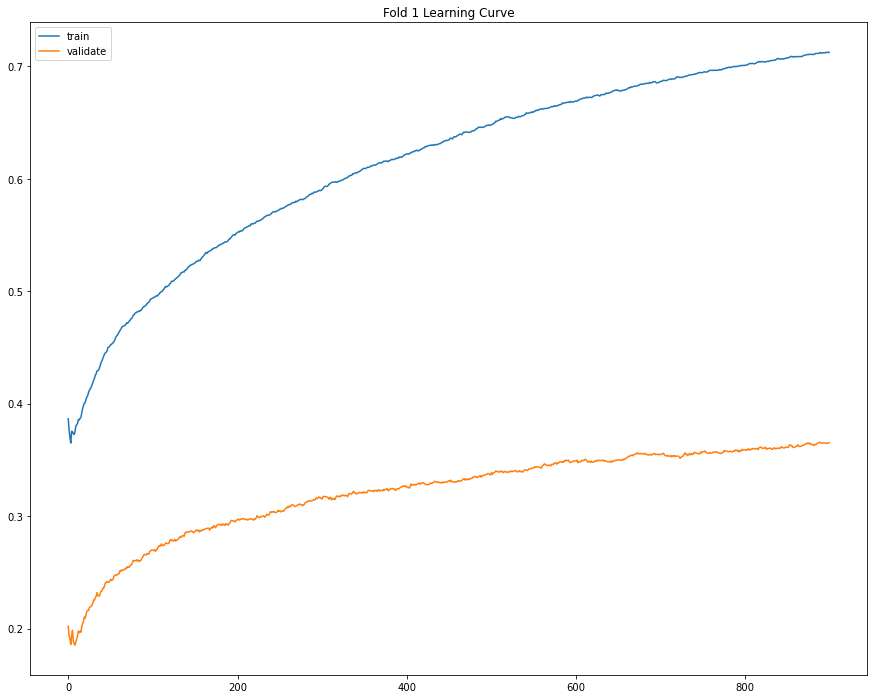

Text(0.5, 1.0, 'Fold 2 Learning Curve')

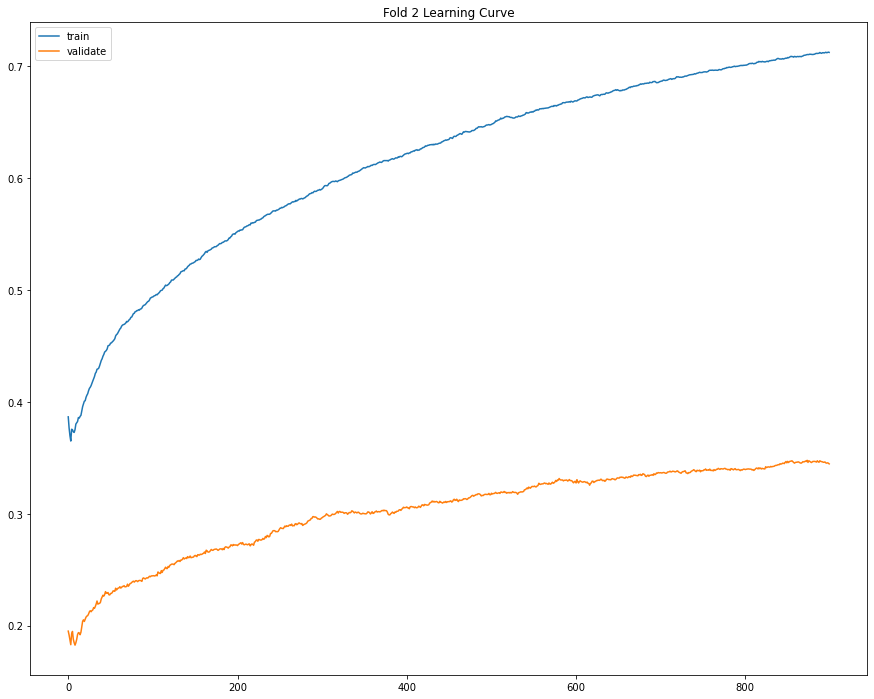

Text(0.5, 1.0, 'Fold 3 Learning Curve')

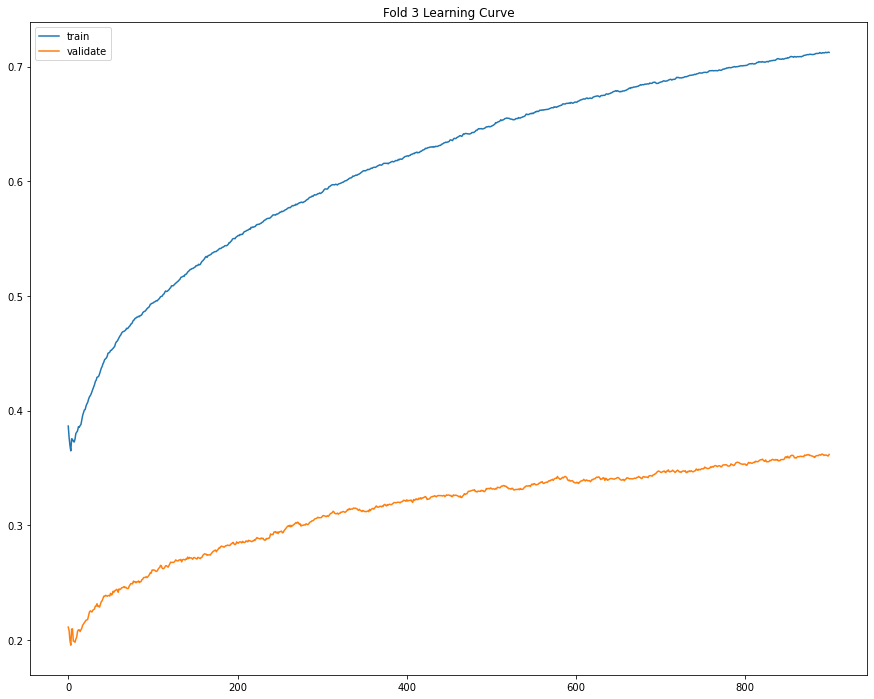

Text(0.5, 1.0, 'Fold 4 Learning Curve')

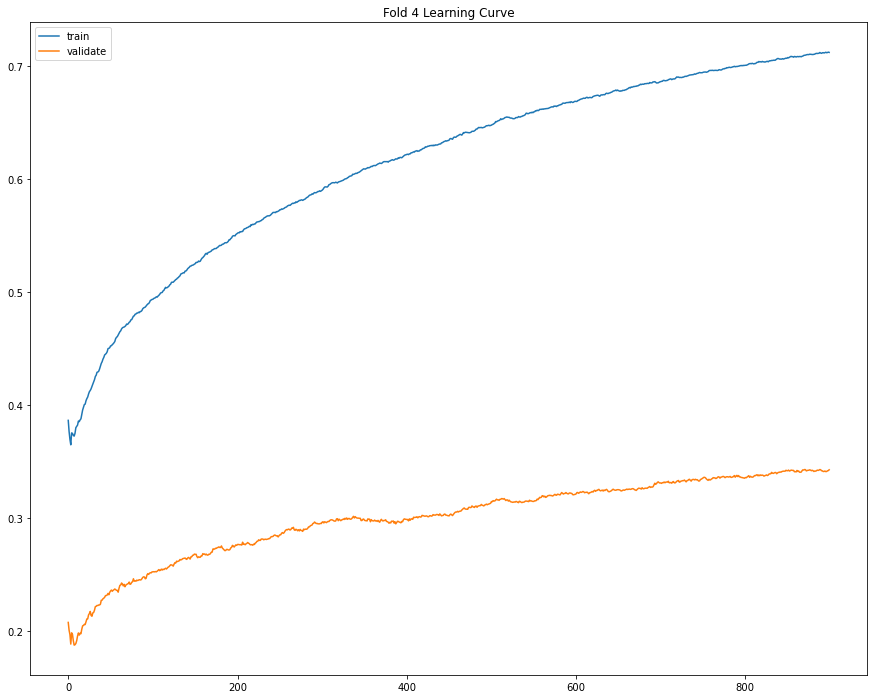

Text(0.5, 1.0, 'Fold 5 Learning Curve')

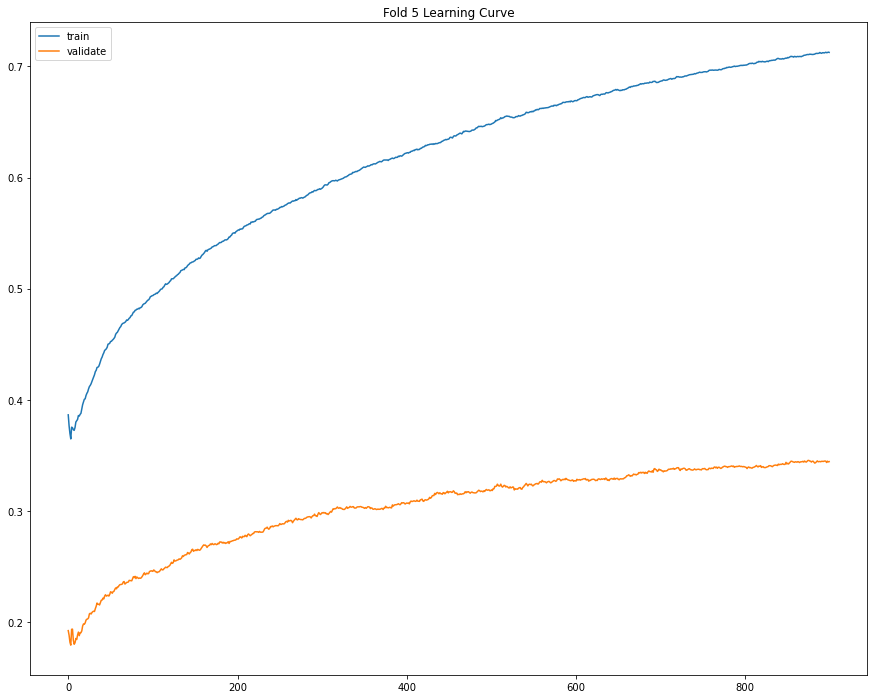

In [133]:
for fold in range(5):
    eval_result = joblib.load(model_path + f'optuna_eval_fold_{fold + 1}.joblib')
    plt.plot(eval_result['train']['avgRecall'], label='train')
    plt.plot(eval_result['validate']['avgRecall'], label='validate')
    plt.legend()
    plt.title(f'Fold {fold + 1} Learning Curve')
    plt.show()

### Confusion Matrix

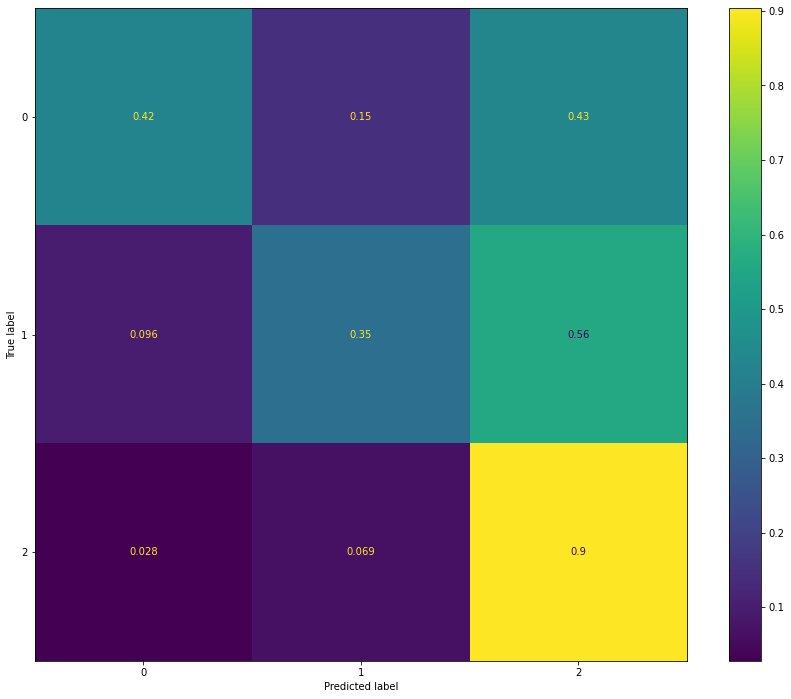

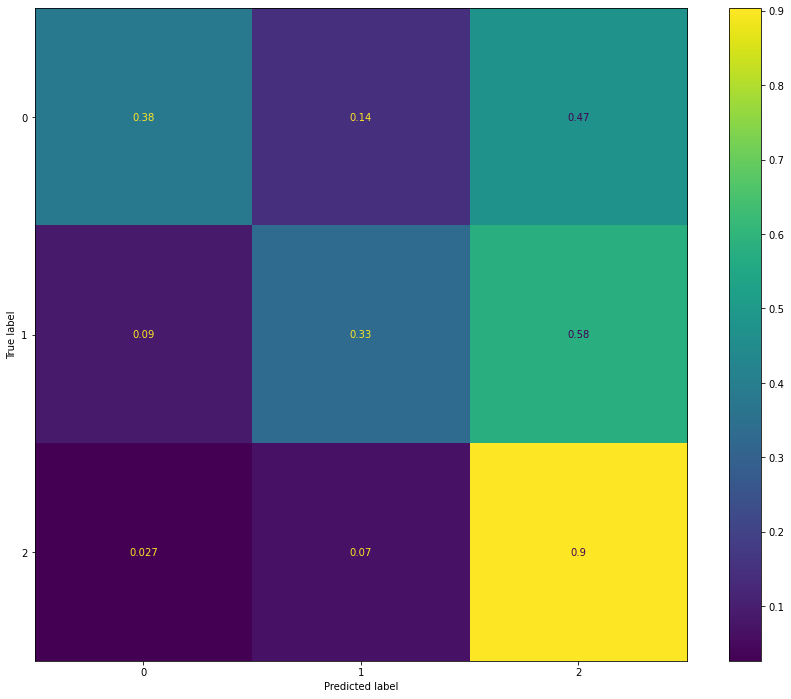

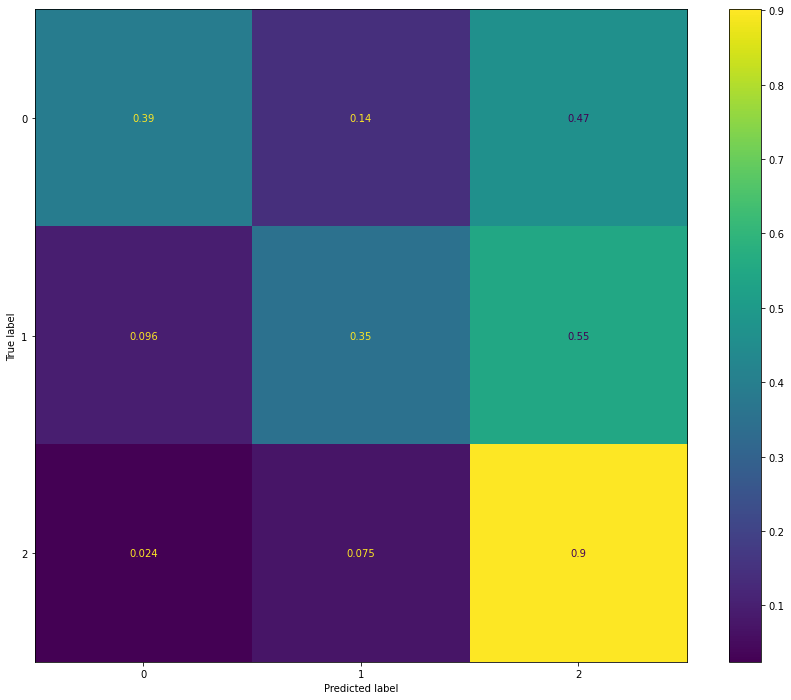

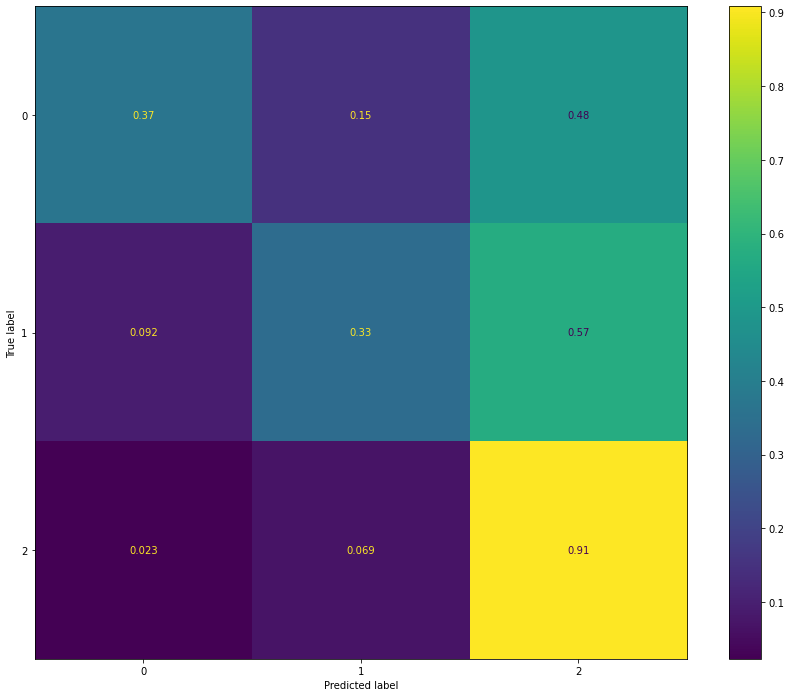

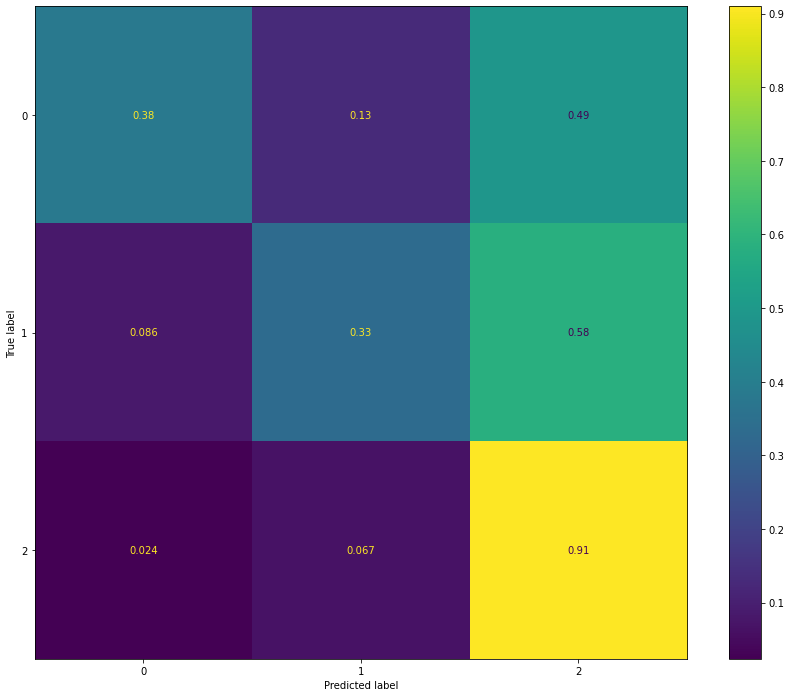

In [134]:
for fold in range(5):
    # Compute predictions for the current fold, summing up the counts across the rows of the matrices for each true label
    ConfusionMatrixDisplay(confusion_matrix(y_true=oof[f'fold_{fold + 1}']['target'], y_pred=np.argmax(oof[f'fold_{fold + 1}']['prediction'], axis=1), labels=[0, 1, 2], normalize='true')).plot();
    plt.show()

## Performance on Test Data

In [146]:
test_X, test_y = pd.read_parquet(data_path + 'test_X.parquet'), pd.read_parquet(data_path + 'test_y.parquet').to_numpy().reshape(-1,)
test_X.shape, test_y.shape

((20354, 49), (20354,))

In [148]:
test_y = label_encoder.transform(test_y)
test_y

array([2, 2, 2, ..., 1, 1, 1])

In [137]:
pred = np.zeros(shape=(test_X.shape[0], 3))
for i in range(5):
    # Initialize the model
    model = xgb.Booster()
    # Load the model
    model.load_model(model_path + f'optuna_model_fold_{i + 1}.xgb')
    # Process test set
    fold_test_X = joblib.load(f'../outputs/pipeline/optuna_preprocessor_fold_{i + 1}.joblib').transform(test_X)
    fold_test_X = joblib.load(f'../outputs/pipeline/optuna_feature_selector_fold_{i + 1}.joblib').transform(fold_test_X)
    # Make predictions on the test set and sum the matrices of probabilities with shape (n_samples, n_classes) element-wise
    pred += model.predict(xgb.DMatrix(data=fold_test_X))
# Average the predictions
pred /= 5
pred = pred.astype('float64')

### Confusion Matrix

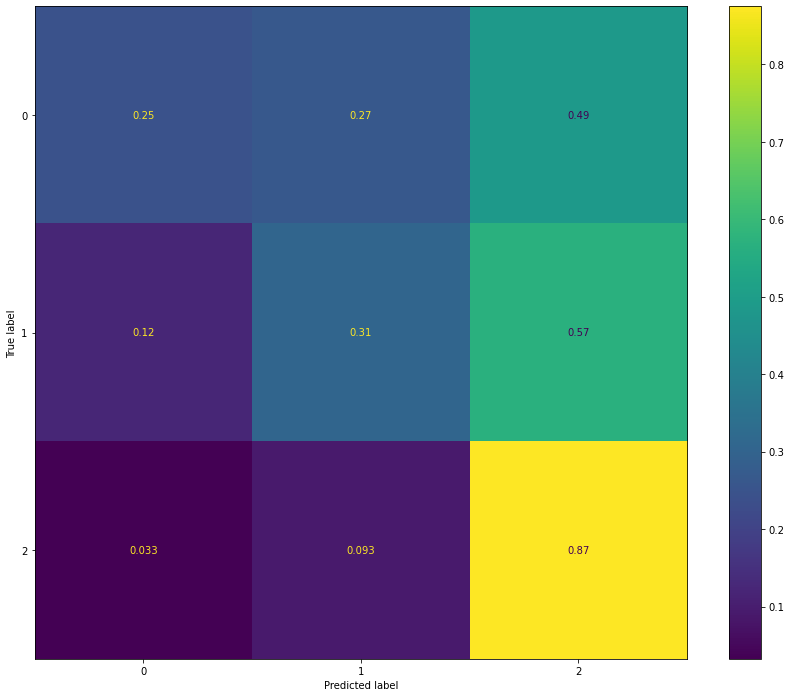

In [160]:
ConfusionMatrixDisplay(confusion_matrix(y_true=test_y, y_pred=np.argmax(pred, axis=1), labels=[0, 1, 2], normalize='true')).plot();
plt.show()

### One Versus Rest ROC Curves

In [140]:
roc_auc_score(
    test_y,
    pred,
    multi_class='ovr',
    average='weighted',
)

0.7163957567290595

In [162]:
target_names = label_encoder.classes_.tolist()
target_names

['<30', '>30', 'NO']

We need to one-hot the test target vector in order to plot the one versus rest ROC curves:

In [149]:
label_binarizer = LabelBinarizer().fit(train_y)
test_y_one_hot = label_binarizer.transform(test_y)
test_y_one_hot

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

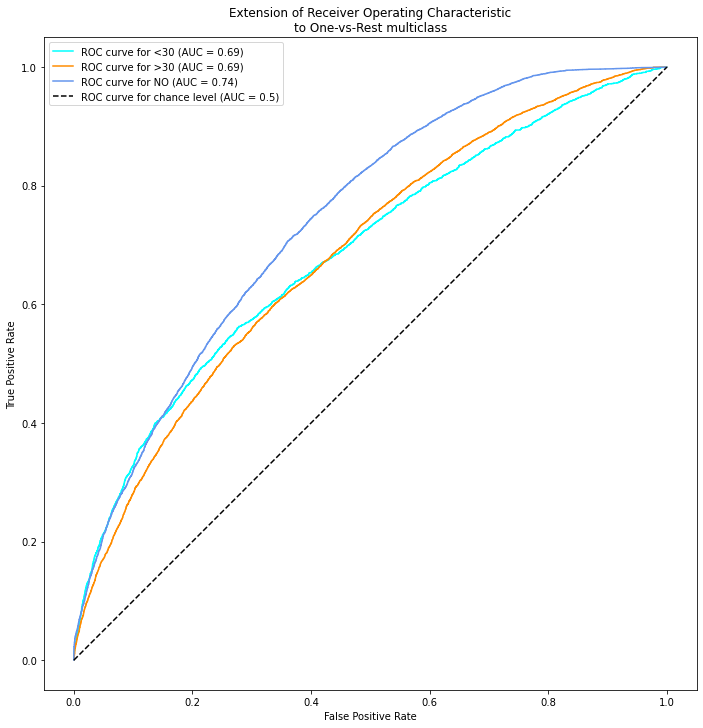

In [163]:
fig, ax = plt.subplots(figsize=(15, 12))

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        test_y_one_hot[:, class_id],
        pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show();

### One Versus One ROC Curves

In [161]:
# All unique combinations of pairs of classes
pair_list = list(combinations(np.unique(test_y), 2))
print(pair_list)

[(0, 1), (0, 2), (1, 2)]


(-0.05, 1.05, -0.05, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, '<30 vs 1 ROC curves')

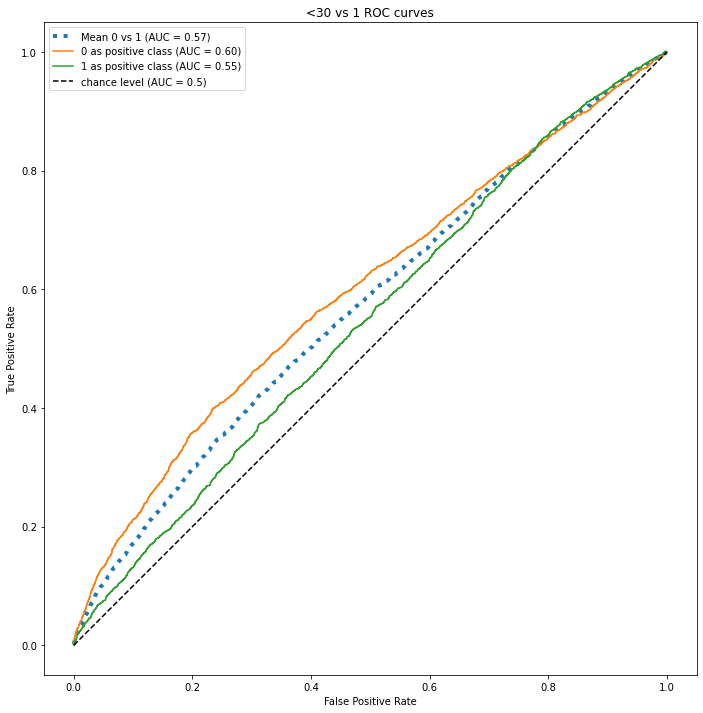

(-0.05, 1.05, -0.05, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, '<30 vs 2 ROC curves')

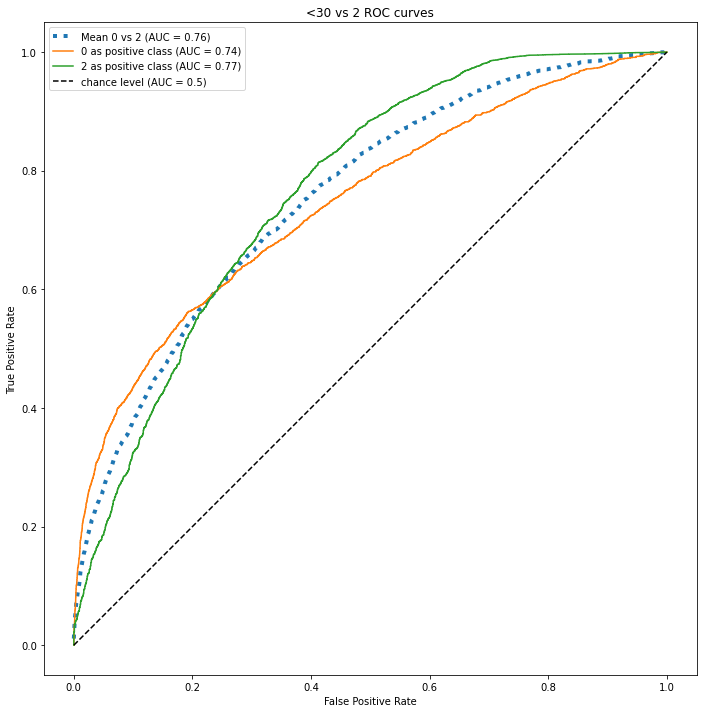

(-0.05, 1.05, -0.05, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, '>30 vs 2 ROC curves')

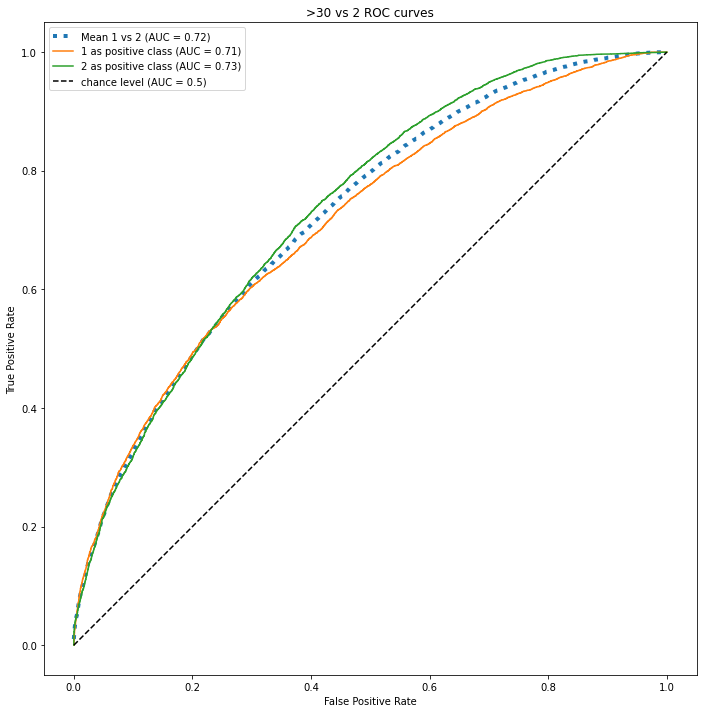

Macro-averaged One-vs-One ROC AUC score:
0.68


In [172]:
pair_scores = []
mean_tpr = dict()
fpr_grid = np.linspace(0, 1, 1000) # For interpolation

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = test_y == label_a
    b_mask = test_y == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, pred[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, pred[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(15, 12))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        pred[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        pred[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{target_names[idx_a]} vs {label_b} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")